In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA

In [3]:
df_temp = pd.read_csv('cleaned_data.csv')
df = df_temp.drop(columns=['Unnamed: 0'])
df.head()

male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   TenYearCHD  
0           0  
1           0  
2           0  
3           1  
4           0

# Preprocessing

In [4]:
cate_columns = ['male', 'education','currentSmoker','BPMeds','prevalentStroke','prevalentHyp','diabetes','TenYearCHD']
df[cate_columns] = df[cate_columns].astype('category')
df.head()

numeric_cols = df.select_dtypes(include='number').columns
categorical_cols = df.select_dtypes(include='category').columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

preprocessed_array = preprocessor.fit_transform(df)

numeric_names = numeric_cols
categorical_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
all_column_names = list(numeric_names) + list(categorical_names)
preprocessed_df = pd.DataFrame(preprocessed_array, columns=all_column_names)

preprocessed_df.drop(columns=['TenYearCHD_0', 'TenYearCHD_1'], inplace=True)
preprocessed_df.head()

age  cigsPerDay   totChol     sysBP     diaBP       BMI  heartRate  \
0 -1.232790   -0.758066 -0.949812 -1.195682 -1.078271  0.292165   0.340047   
1 -0.414581   -0.758066  0.303664 -0.514247 -0.156660  0.723055   1.585513   
2 -0.180807    0.918004  0.189712 -0.218959 -0.240443 -0.106898  -0.075108   
3  1.338723    1.756040 -0.266098  0.803194  1.016300  0.686332  -0.905419   
4 -0.414581    1.169415  1.101330 -0.105386  0.094689 -0.655303   0.755203   

    glucose  male_0  male_1  ...  currentSmoker_0  currentSmoker_1  \
0 -0.207187     0.0     1.0  ...              1.0              0.0   
1 -0.250979     1.0     0.0  ...              1.0              0.0   
2 -0.513730     0.0     1.0  ...              0.0              1.0   
3  0.931401     1.0     0.0  ...              0.0              1.0   
4  0.143148     1.0     0.0  ...              0.0              1.0   

   BPMeds_0.0  BPMeds_1.0  prevalentStroke_0  prevalentStroke_1  \
0         1.0         0.0                1.0                0.0   
1         1.0         0.0                1.0                0.0   
2         1.0         0.0                1.0                0.0   
3         1.0         0.0                1.0                0.0   
4         1.0         0.0                1.0                0.0   

   prevalentHyp_0  prevalentHyp_1  diabetes_0  diabetes_1  
0             1.0             0.0         1.0         0.0  
1             1.0             0.0         1.0         0.0  
2             1.0             0.0         1.0         0.0  
3             0.0             1.0         1.0         0.0  
4             1.0             0.0         1.0         0.0  

[5 rows x 24 columns]

# Correlation Analysis

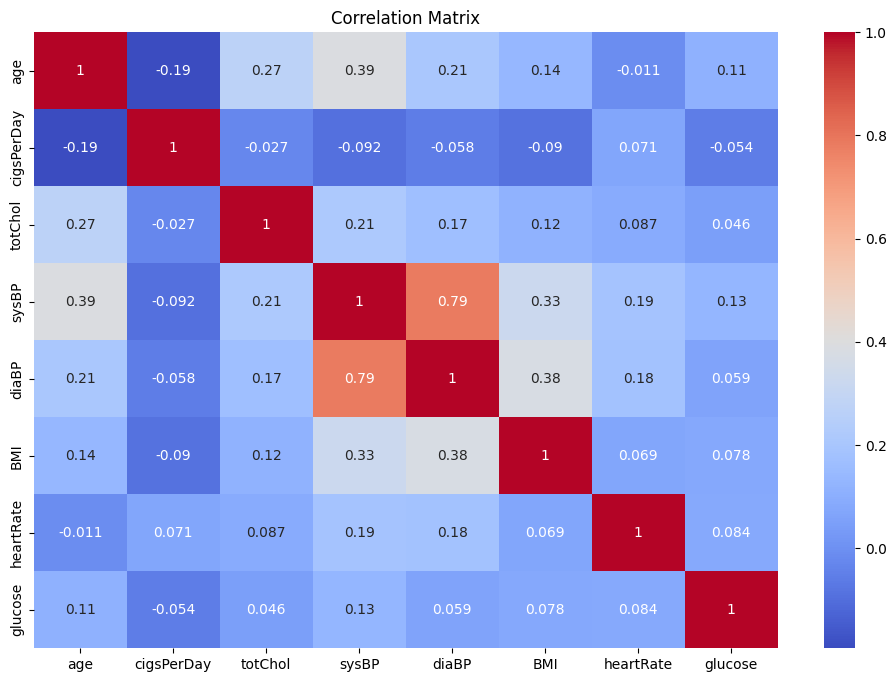

In [5]:
# Numerical Columns

df_num = df[numeric_cols].copy()

plt.figure(figsize=(12,8))
sns.heatmap(df_num.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('num_corr.png')
plt.show()


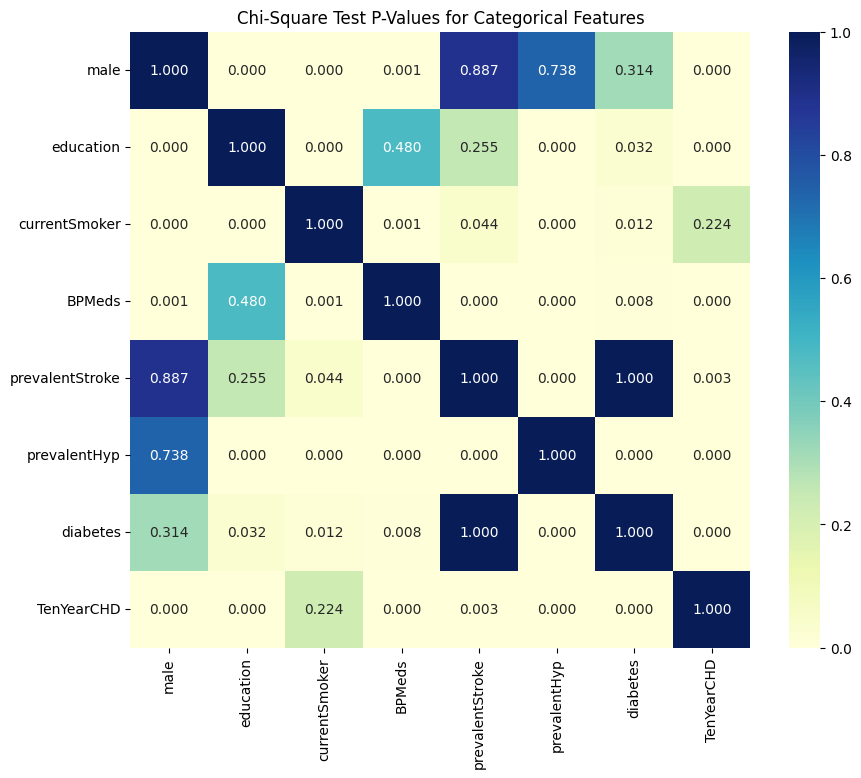

In [6]:
# Categorical Columns

# Create an empty matrix to store p-values
cat_features = df.select_dtypes(include='category').columns
chi2_pvals = pd.DataFrame(index=cat_features, columns=cat_features)

# Loop through pairs of categorical features
for col1 in cat_features:
    for col2 in cat_features:
        if col1 == col2:
            chi2_pvals.loc[col1, col2] = 1.0
        else:
            contingency_table = pd.crosstab(df[col1], df[col2])
            _, p, _, _ = chi2_contingency(contingency_table)
            chi2_pvals.loc[col1, col2] = p

# Convert to numeric for plotting
chi2_pvals = chi2_pvals.astype(float)

# Visualize the p-values as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(chi2_pvals, annot=True, cmap="YlGnBu", cbar=True, fmt=".3f")
plt.title("Chi-Square Test P-Values for Categorical Features")
plt.savefig('cat_corr.png')
plt.show()



In [7]:


from scipy.stats import f_oneway

# Perform ANOVA for all numerical features grouped by each categorical feature
anova_results = {}
for cat_feature in categorical_cols:
    for num_feature in numeric_cols:
        groups = [df[df[cat_feature] == category][num_feature] for category in df[cat_feature].cat.categories]
        f_stat, p_value = f_oneway(*groups)
        anova_results[f"{num_feature} ~ {cat_feature}"] = p_value

anova_results = pd.Series(anova_results).sort_values()
sig_anova_results = anova_results[anova_results < 0.05]
sig_anova_results.sort_values(inplace=True)

anova_results_df = pd.DataFrame(list(anova_results.items()), columns=["Feature Relationship", "p-value"])
sig_anova_results_df = anova_results_df[anova_results_df["p-value"] < 0.05]
sig_anova_results_df["p-value"] = sig_anova_results_df["p-value"].round(2)
sig_anova_results_df = sig_anova_results_df.sort_values(by="p-value")


print("Significant ANOVA Results (p < 0.05):")
sig_anova_results_df

Significant ANOVA Results (p < 0.05):


C:\Users\conno\AppData\Local\Temp\ipykernel_18228\2580820319.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sig_anova_results_df["p-value"] = sig_anova_results_df["p-value"].round(2)


Feature Relationship  p-value
0     cigsPerDay ~ currentSmoker     0.00
27          totChol ~ TenYearCHD     0.00
28              totChol ~ BPMeds     0.00
29                BMI ~ diabetes     0.00
30        glucose ~ prevalentHyp     0.00
31                    BMI ~ male     0.00
32         heartRate ~ education     0.00
33                totChol ~ male     0.00
34     cigsPerDay ~ prevalentHyp     0.00
35              BMI ~ TenYearCHD     0.00
36             diaBP ~ education     0.00
37                  diaBP ~ male     0.00
38       cigsPerDay ~ TenYearCHD     0.00
39     heartRate ~ currentSmoker     0.00
40       sysBP ~ prevalentStroke     0.00
41       glucose ~ currentSmoker     0.00
42              glucose ~ BPMeds     0.00
43       totChol ~ currentSmoker     0.00
44           cigsPerDay ~ BPMeds     0.00
45         age ~ prevalentStroke     0.00
46          heartRate ~ diabetes     0.00
47              diaBP ~ diabetes     0.00
25                age ~ diabetes     0.00
24                  BMI ~ BPMeds     0.00
26              sysBP ~ diabetes     0.00
22              heartRate ~ male     0.00
1             glucose ~ diabetes     0.00
2           sysBP ~ prevalentHyp     0.00
3           diaBP ~ prevalentHyp     0.00
4              cigsPerDay ~ male     0.00
5             age ~ prevalentHyp     0.00
6             BMI ~ prevalentHyp     0.00
7                 sysBP ~ BPMeds     0.00
8                age ~ education     0.00
23         diaBP ~ currentSmoker     0.00
10            sysBP ~ TenYearCHD     0.00
11           age ~ currentSmoker     0.00
9               age ~ TenYearCHD     0.00
13        totChol ~ prevalentHyp     0.00
14           BMI ~ currentSmoker     0.00
15               BMI ~ education     0.00
16      heartRate ~ prevalentHyp     0.00
17            diaBP ~ TenYearCHD     0.00
18                  age ~ BPMeds     0.00
19         sysBP ~ currentSmoker     0.00
20             sysBP ~ education     0.00
21          glucose ~ TenYearCHD     0.00
12                diaBP ~ BPMeds     0.00
48        cigsPerDay ~ education     0.01
49       diaBP ~ prevalentStroke     0.01
50            totChol ~ diabetes     0.01
52                  sysBP ~ male     0.02
51         cigsPerDay ~ diabetes     0.02
53  cigsPerDay ~ prevalentStroke     0.02

# Interaction Effects

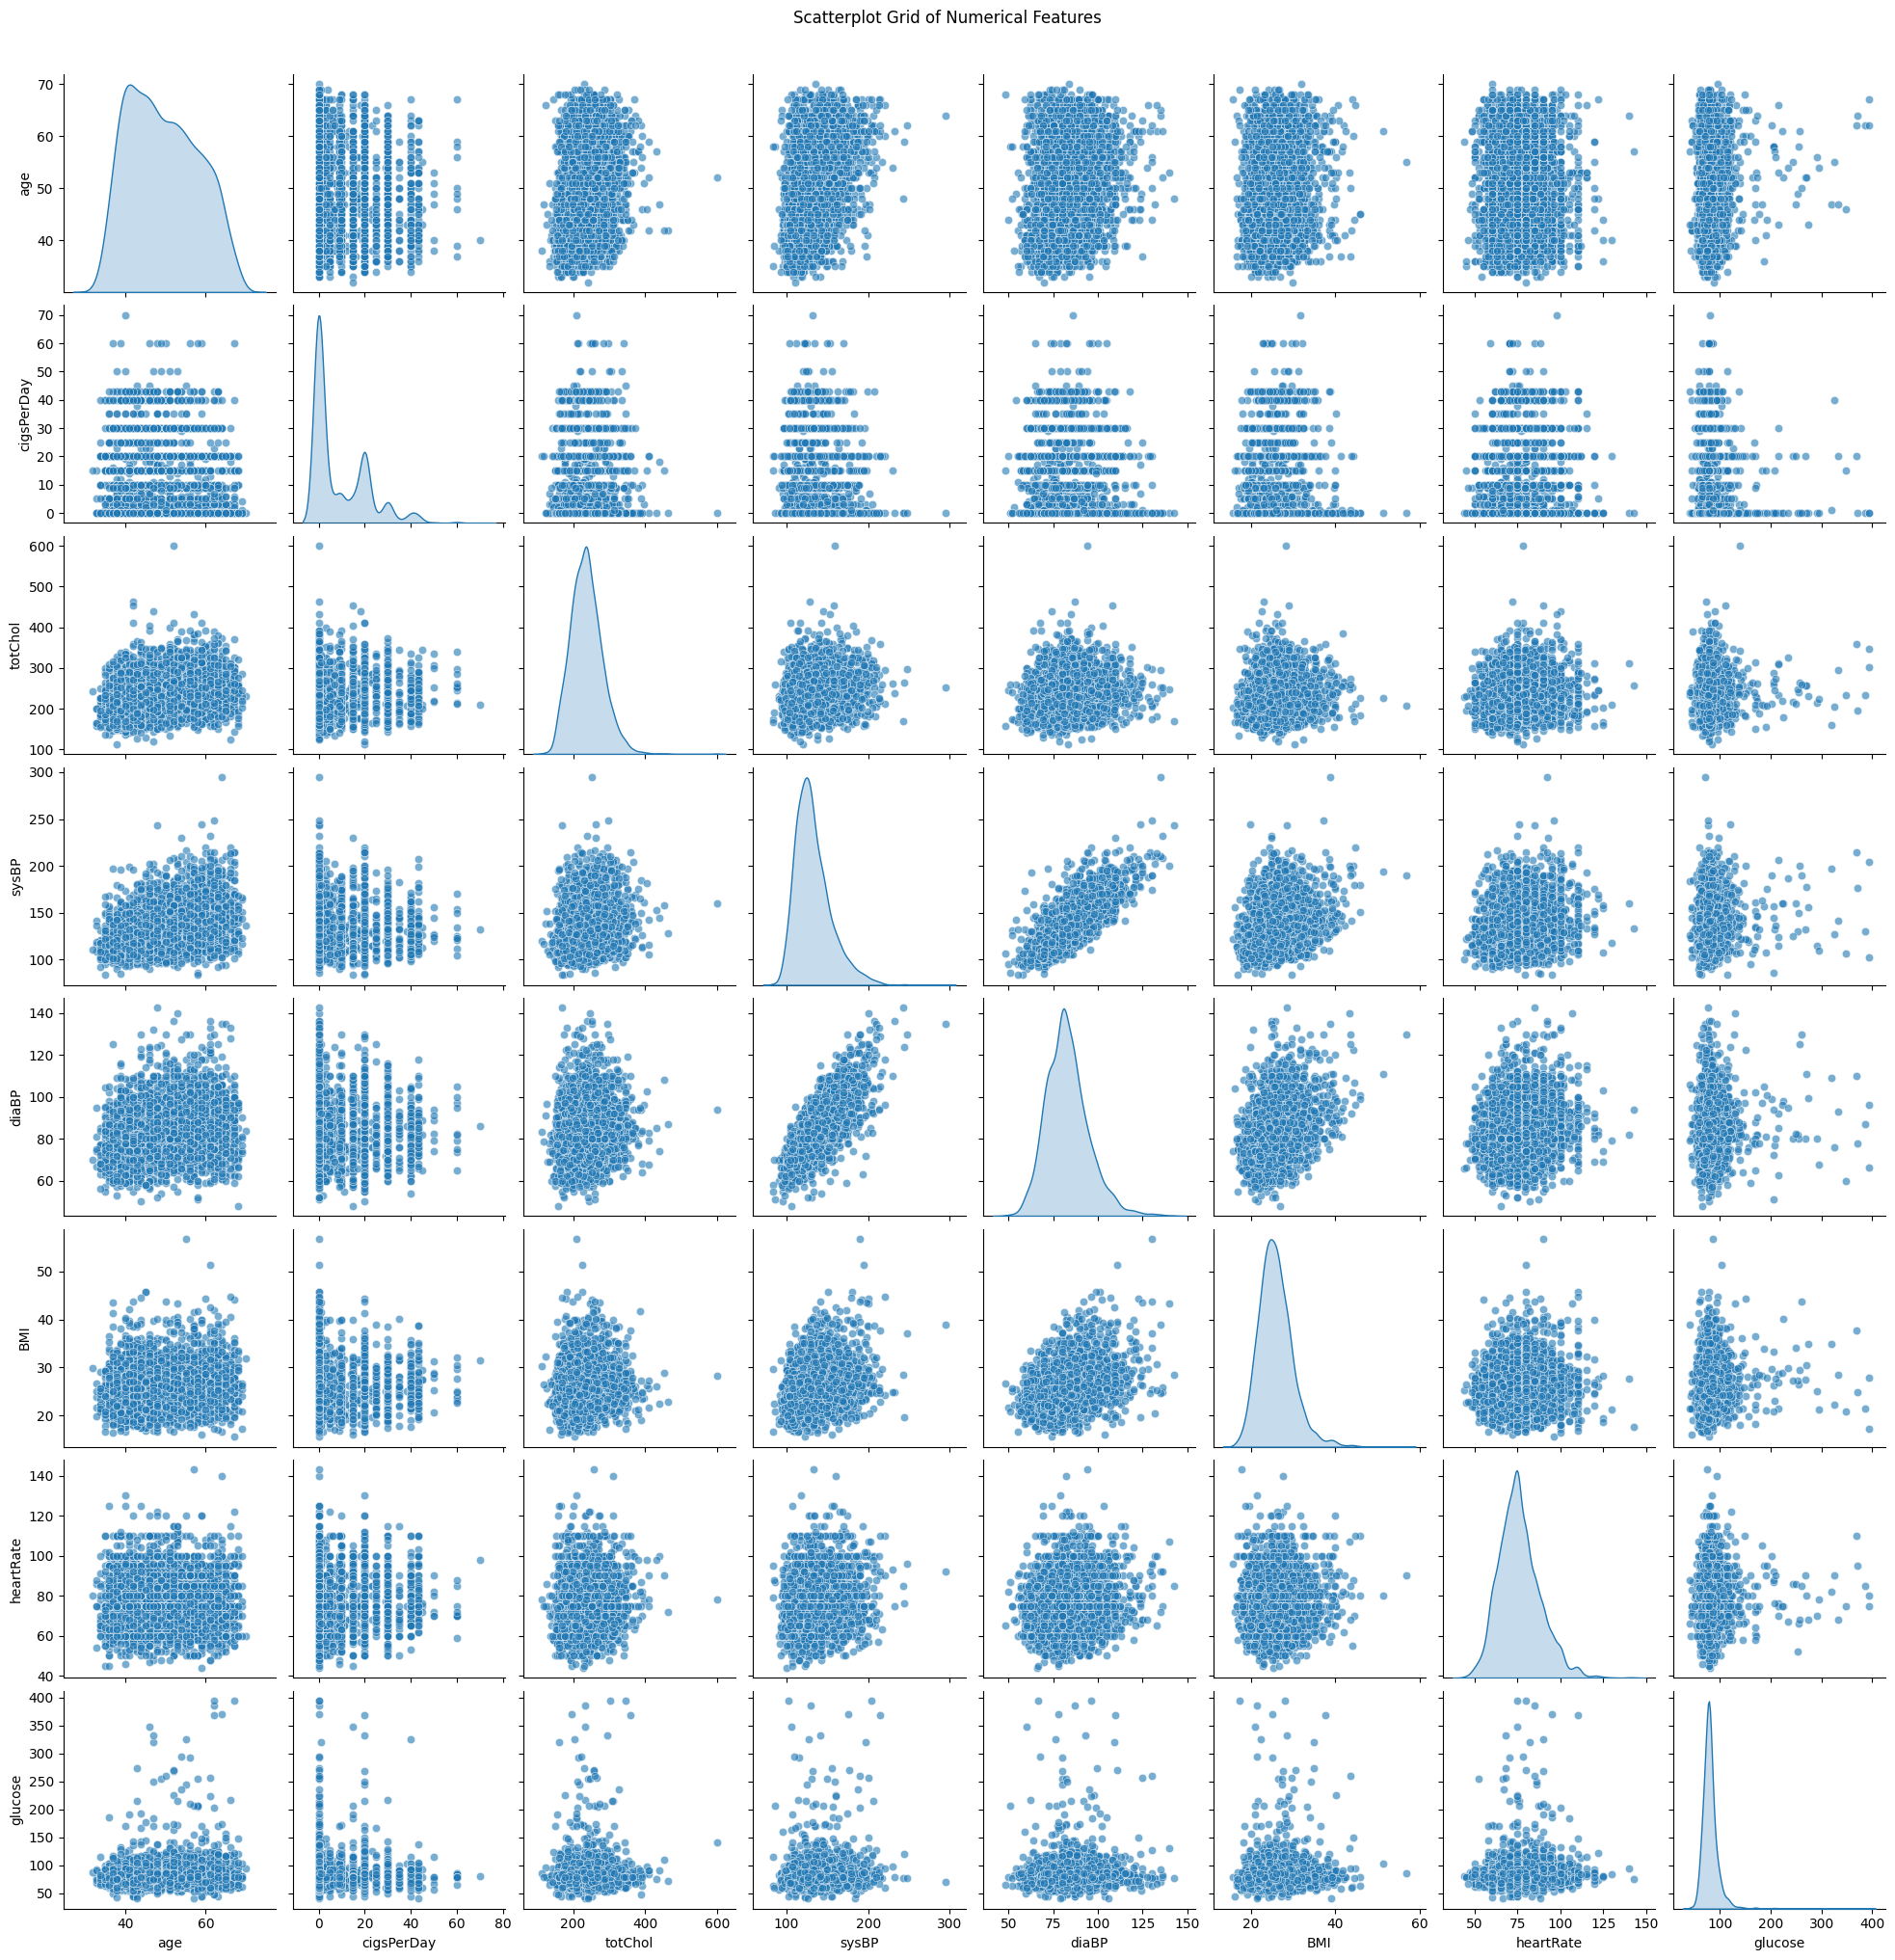

In [8]:
# Numerical-Numerical

import seaborn as sns
import matplotlib.pyplot as plt

# Select the numerical features
numerical_features = df.select_dtypes(include='number').columns

# Create a pairplot for the numerical features
sns.pairplot(df[numerical_features], diag_kind="kde", plot_kws={'alpha': 0.6})

# Add a title
plt.suptitle("Scatterplot Grid of Numerical Features", y=1.02)
plt.show()


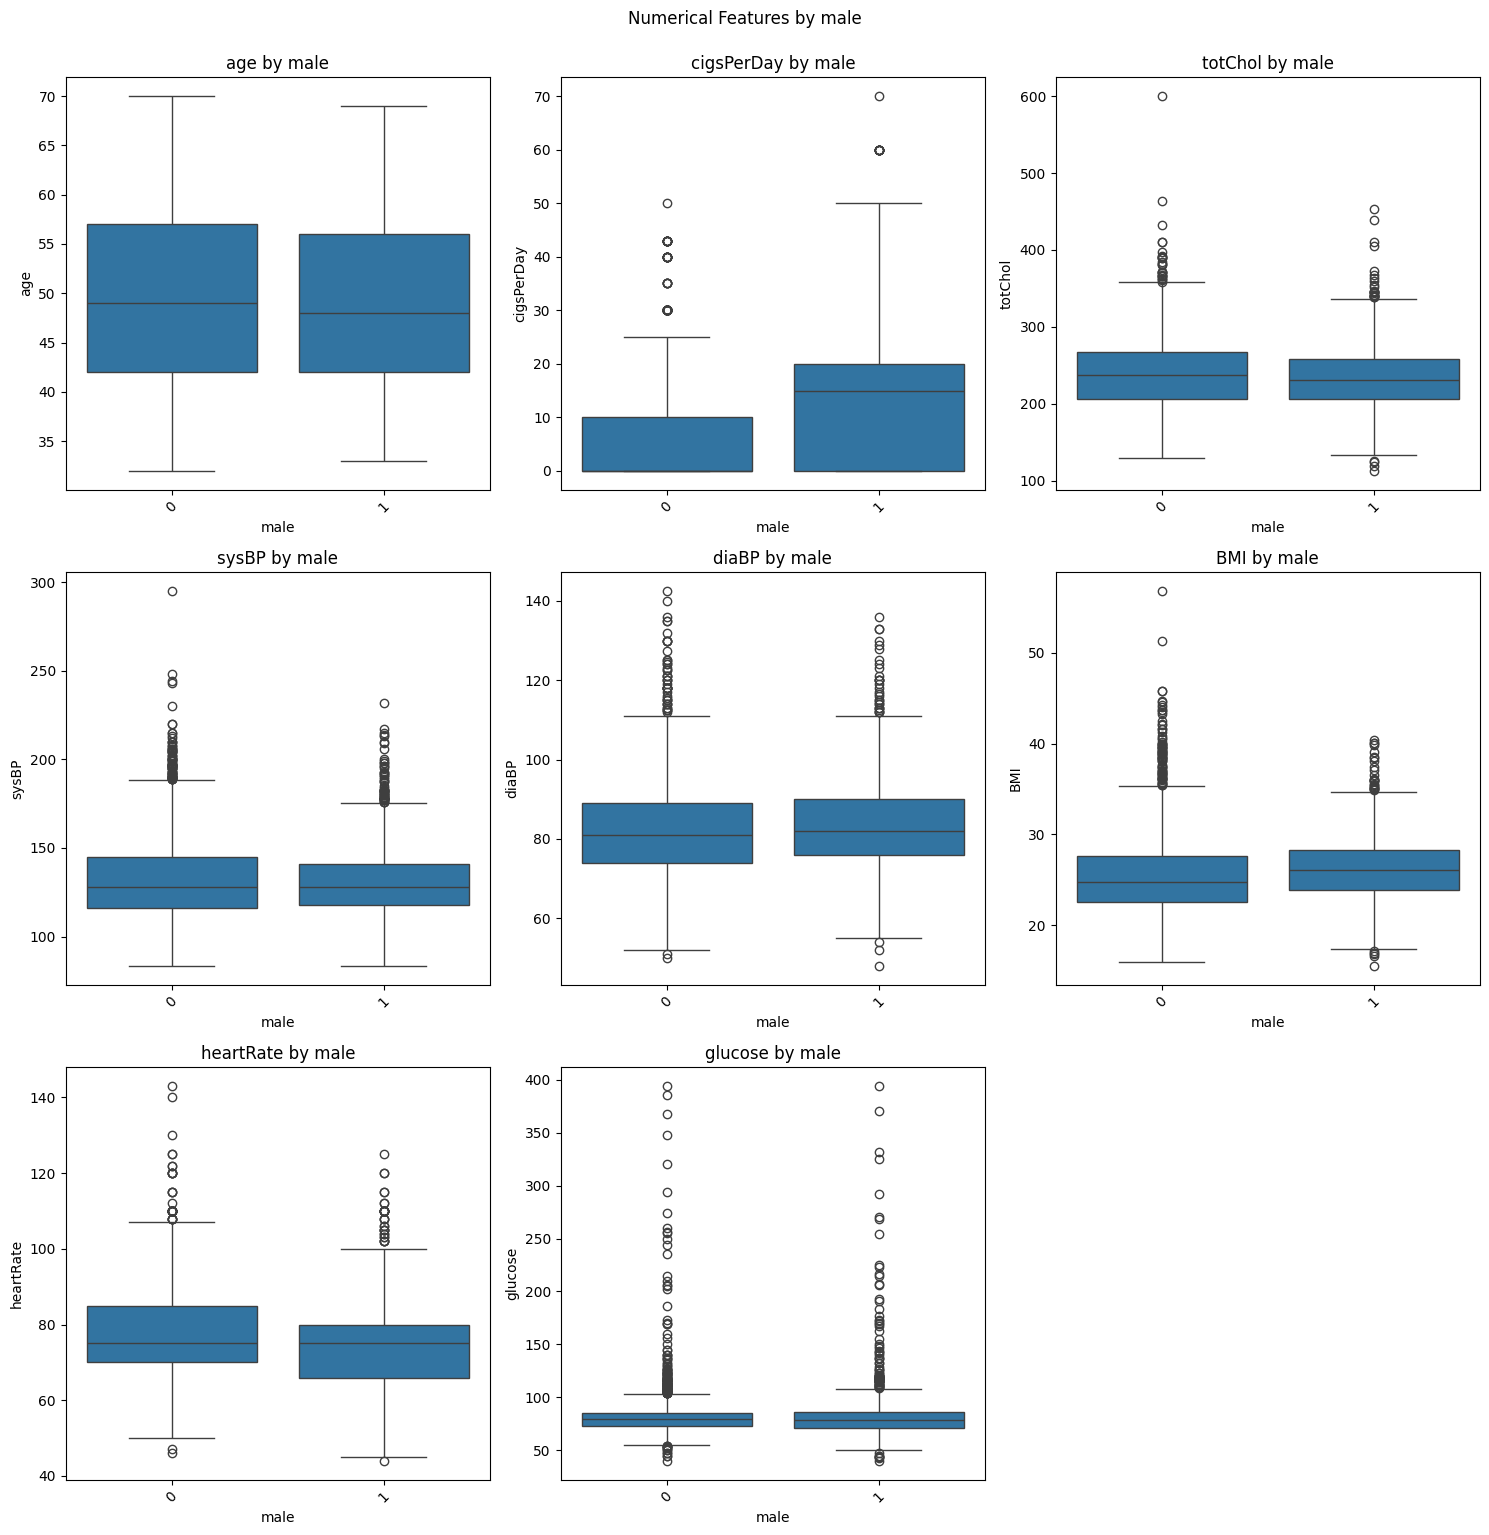

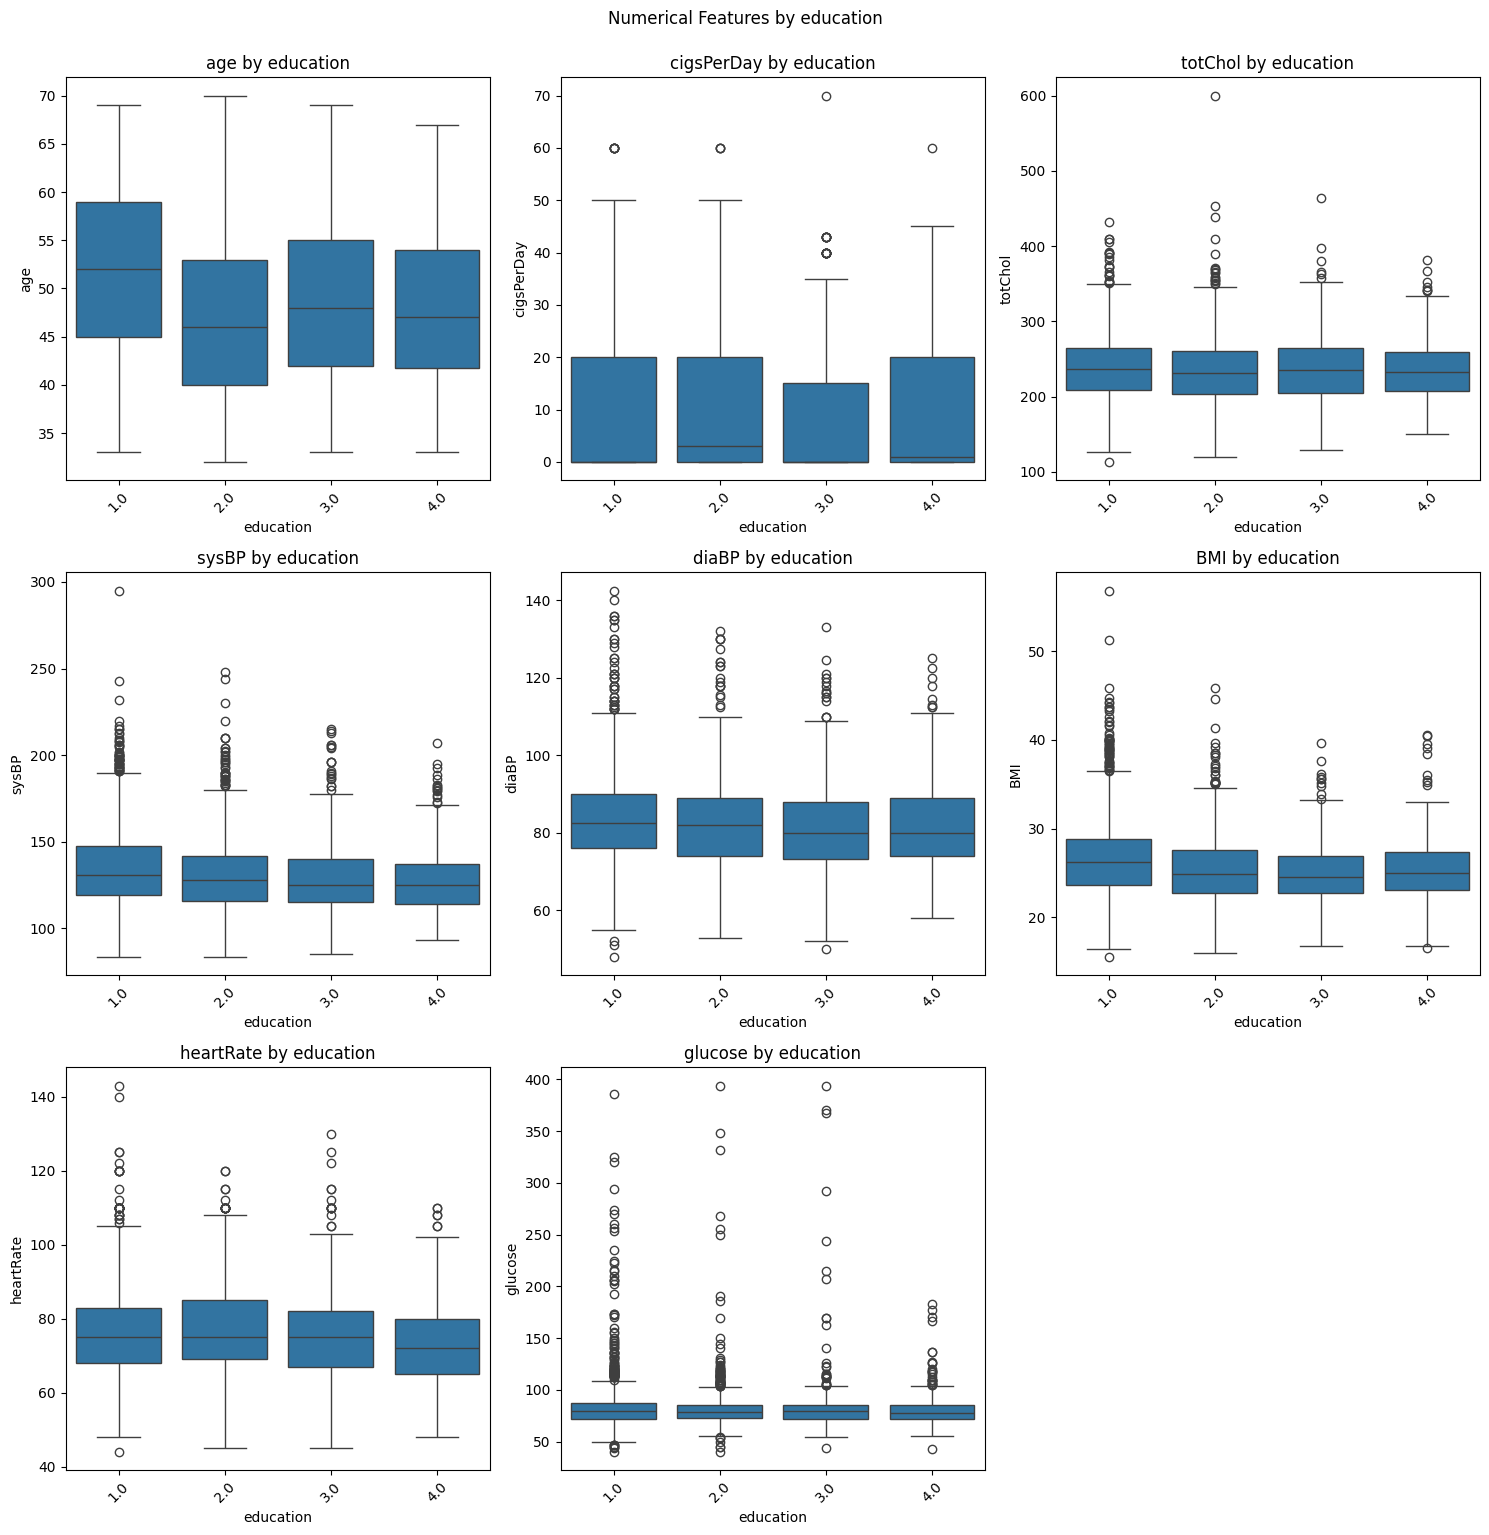

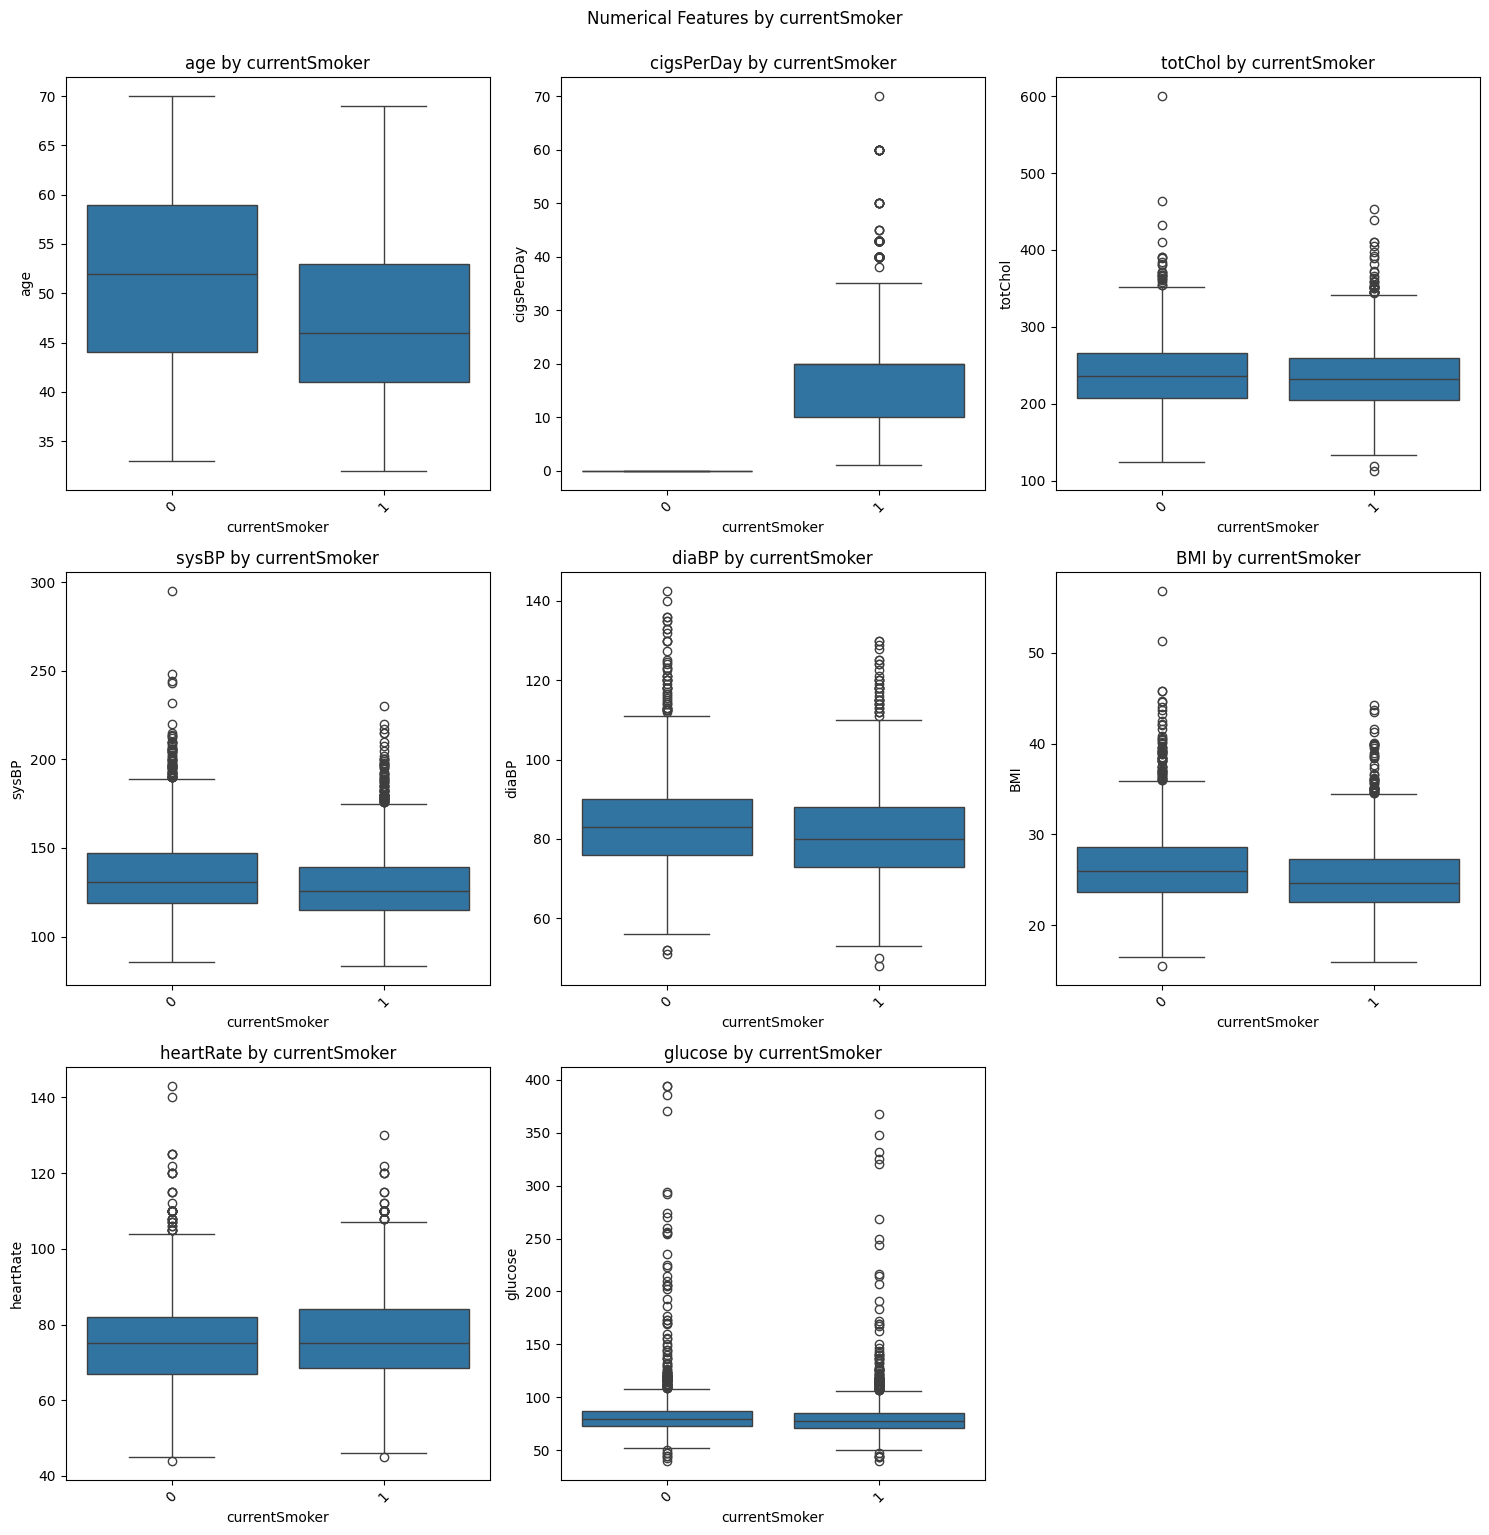

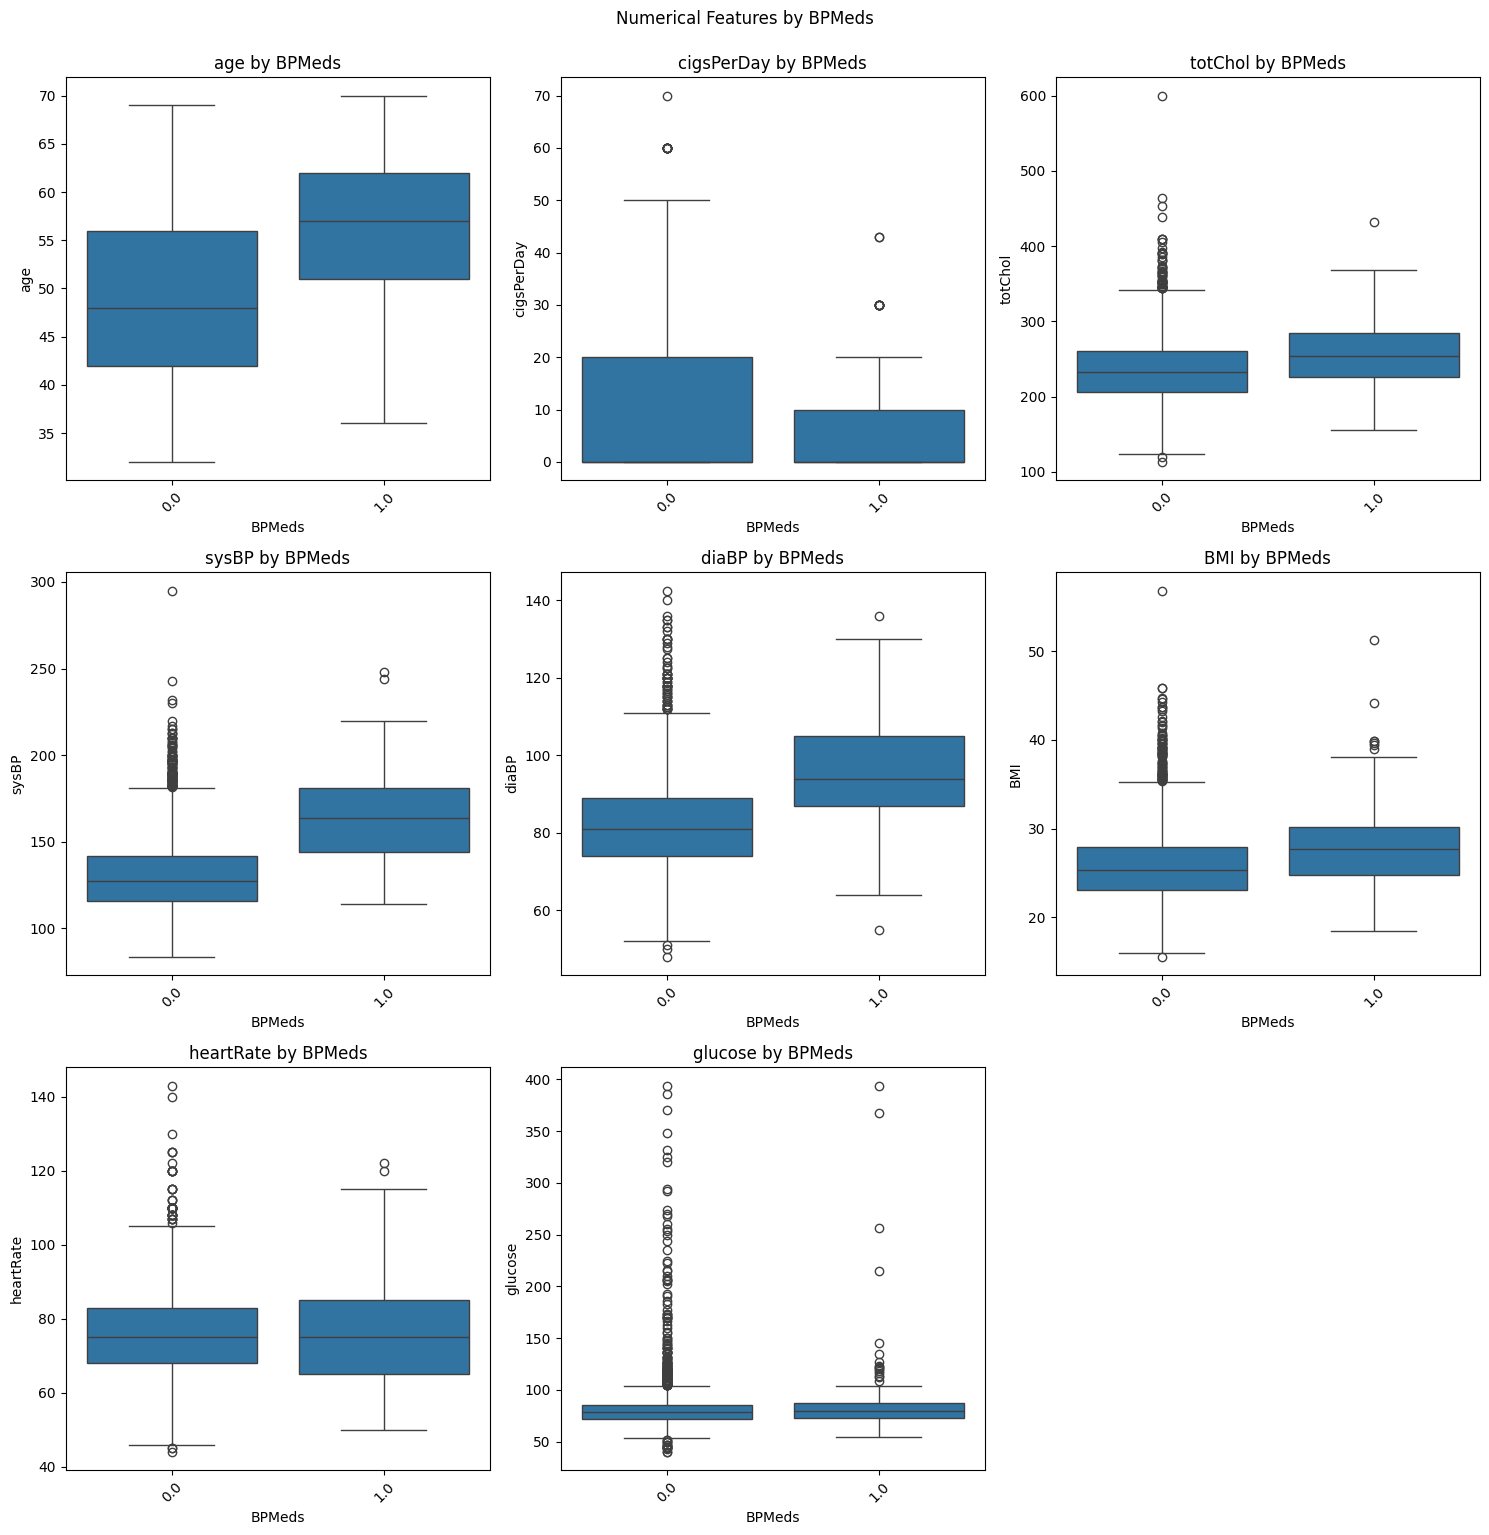

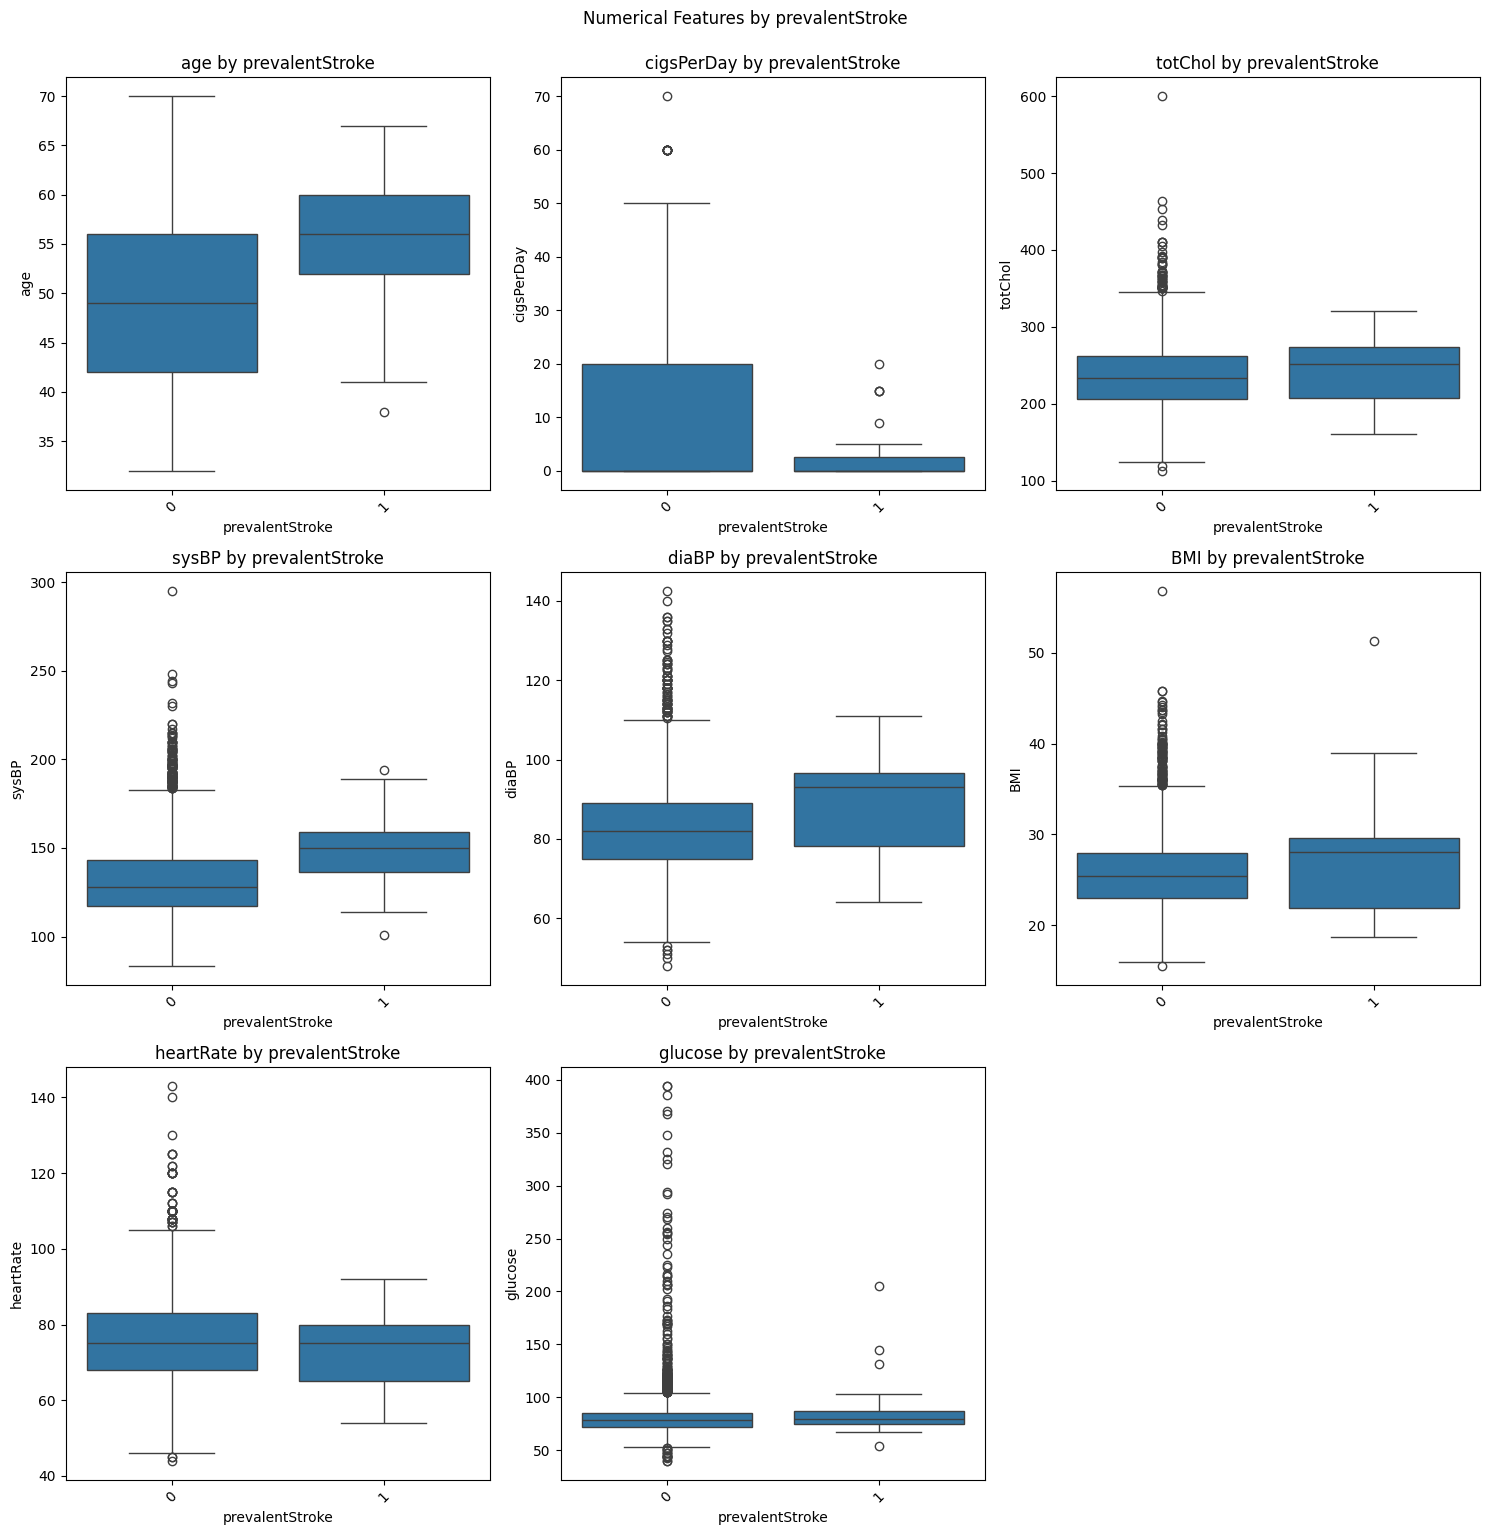

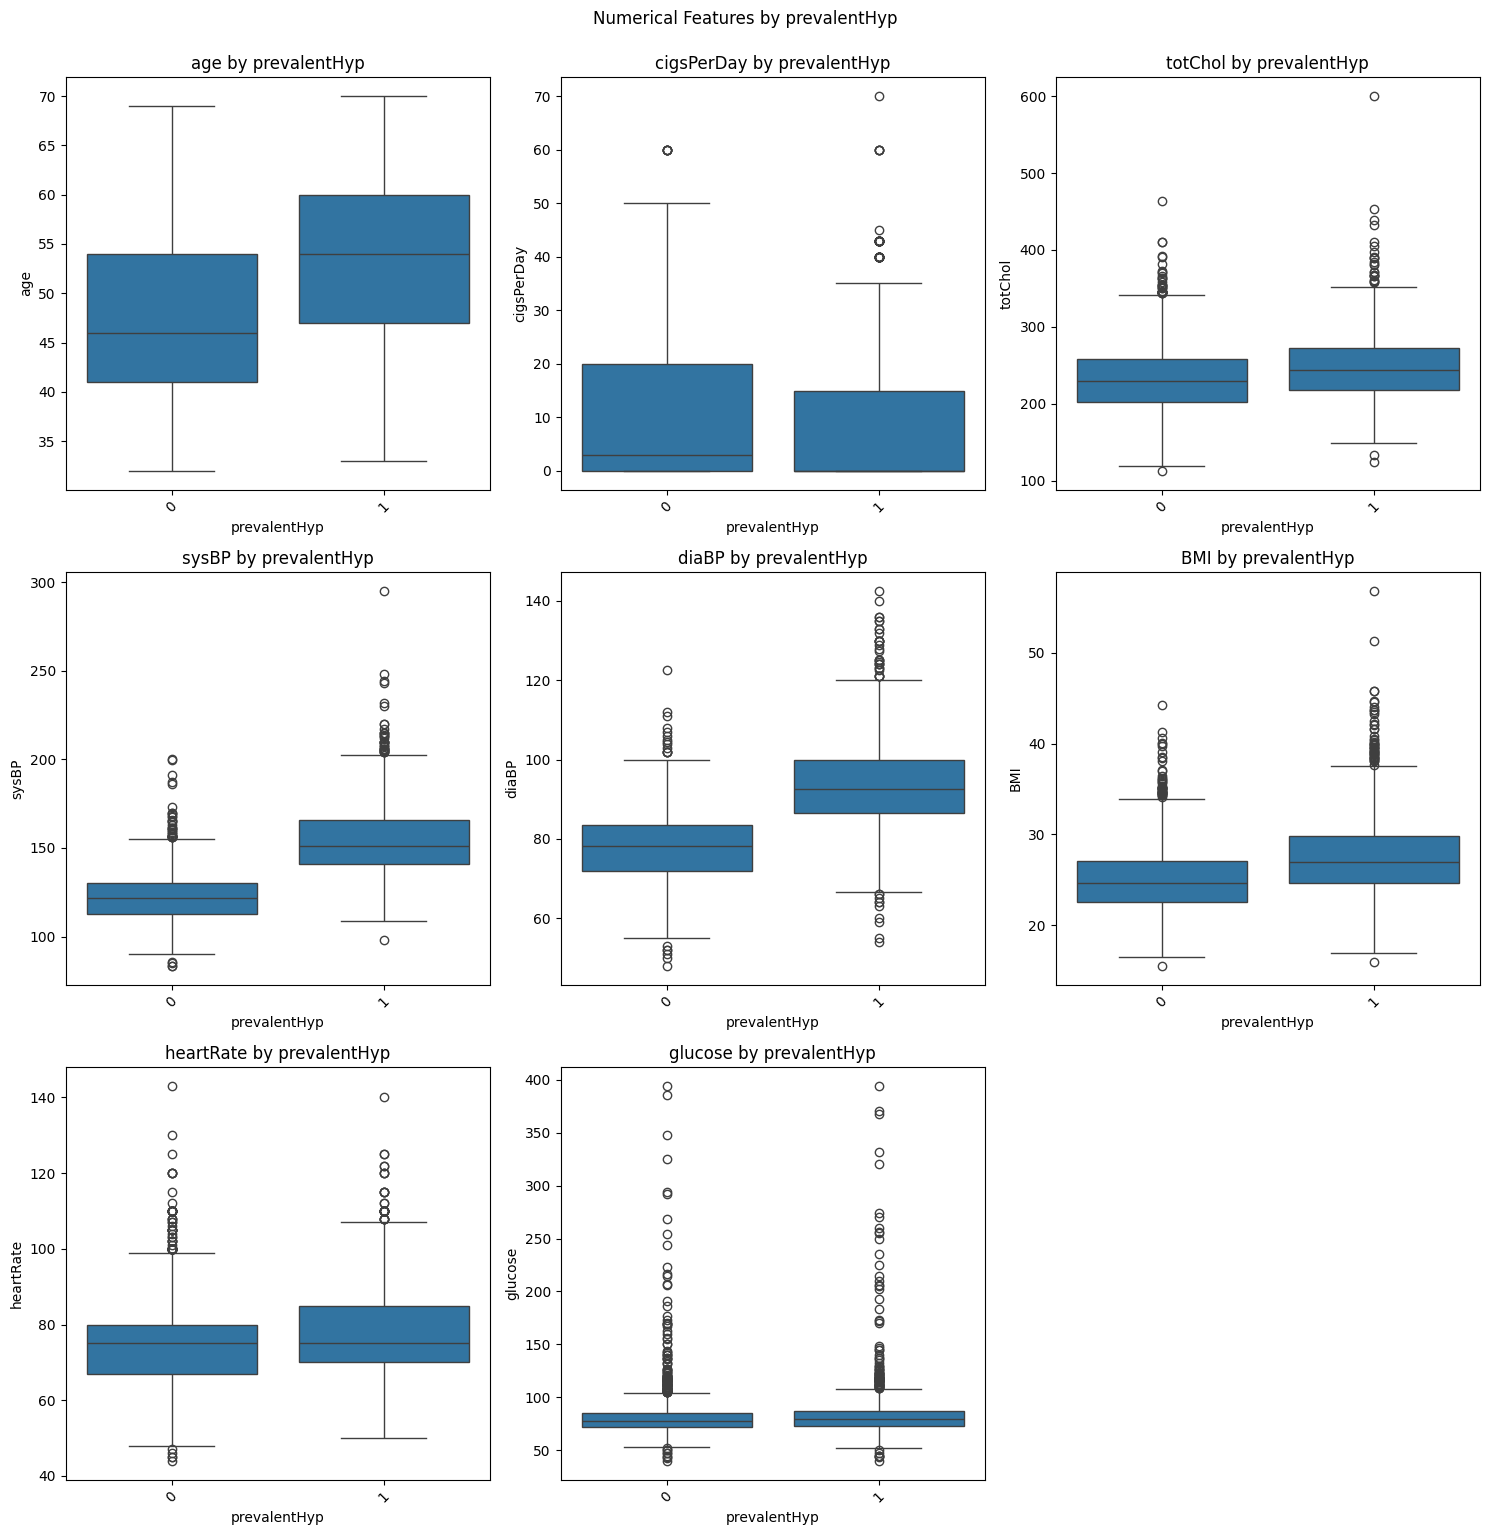

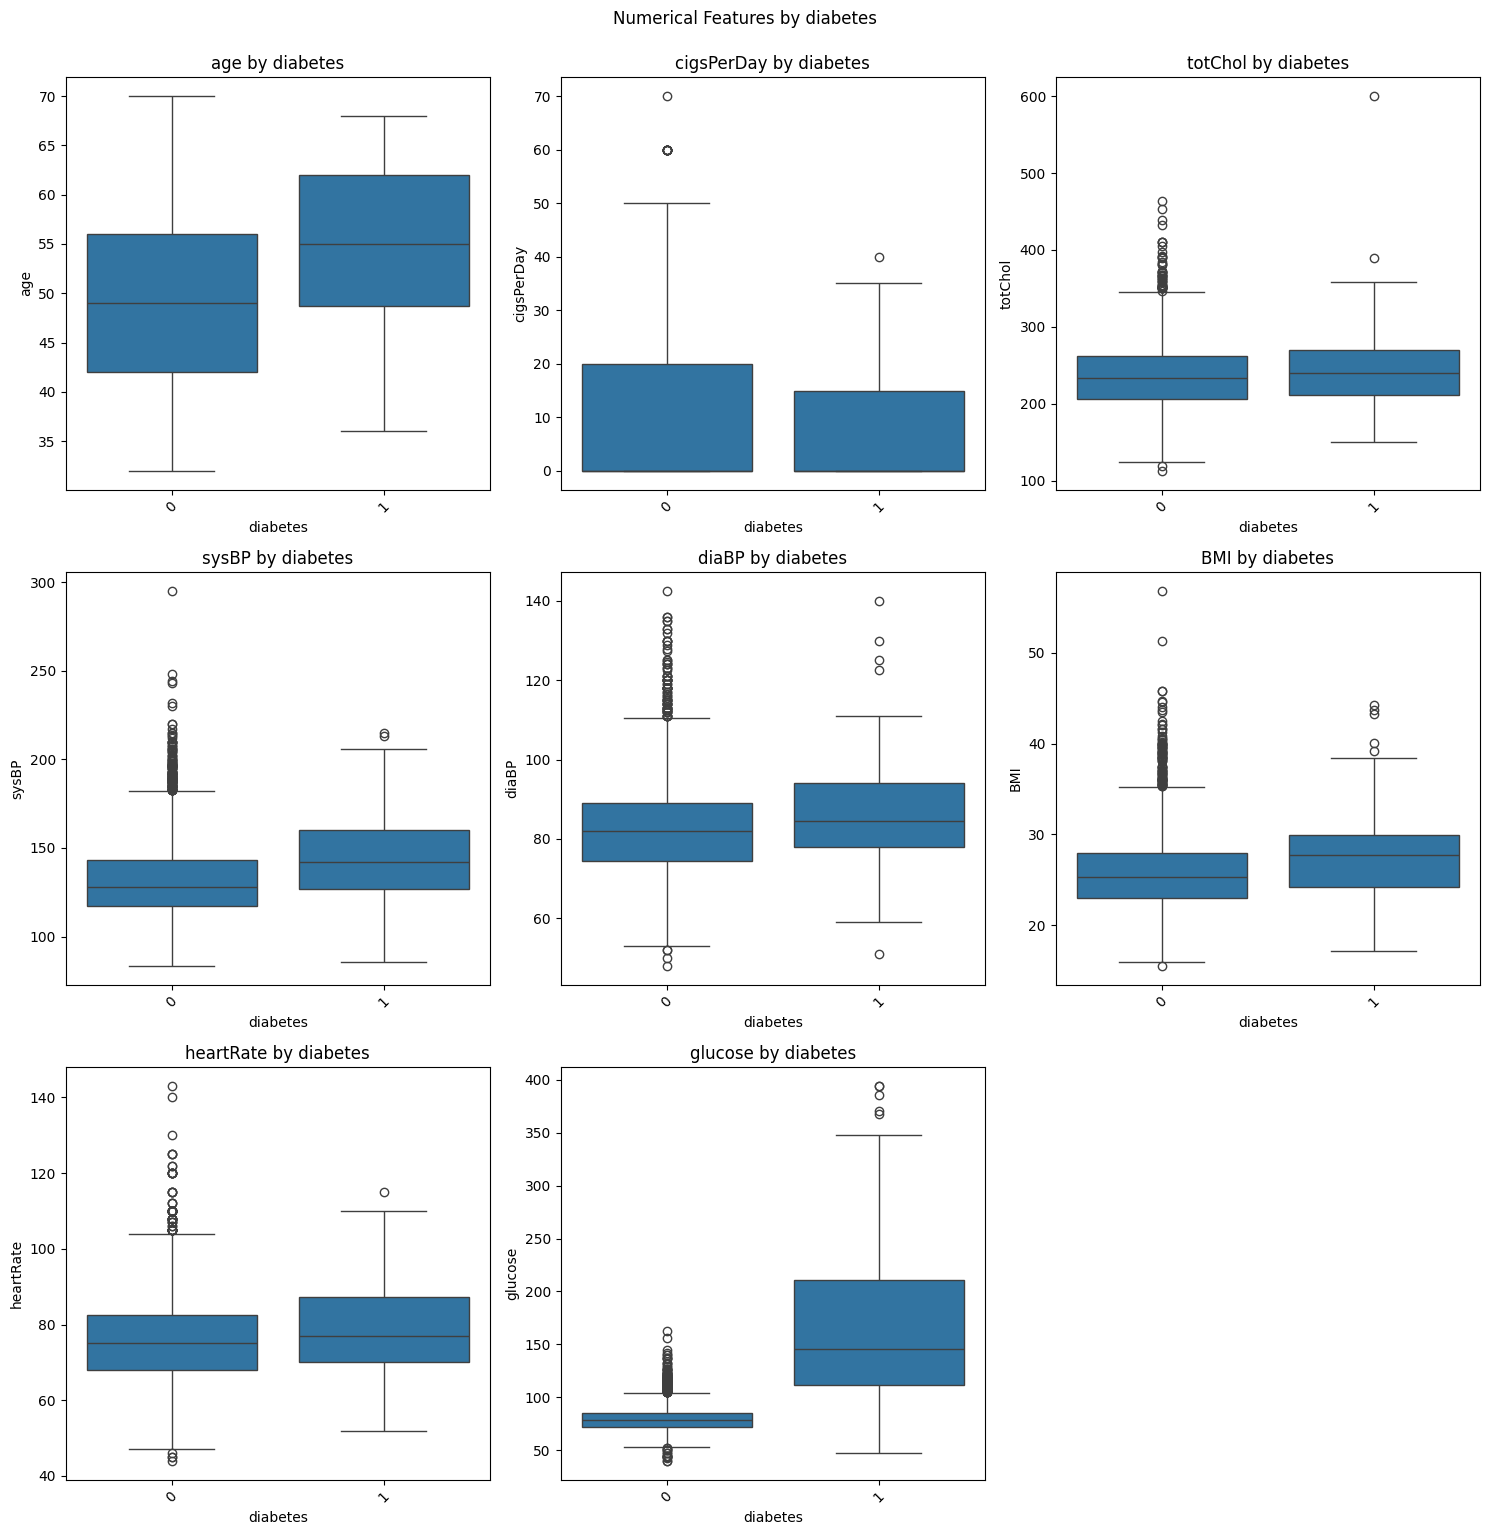

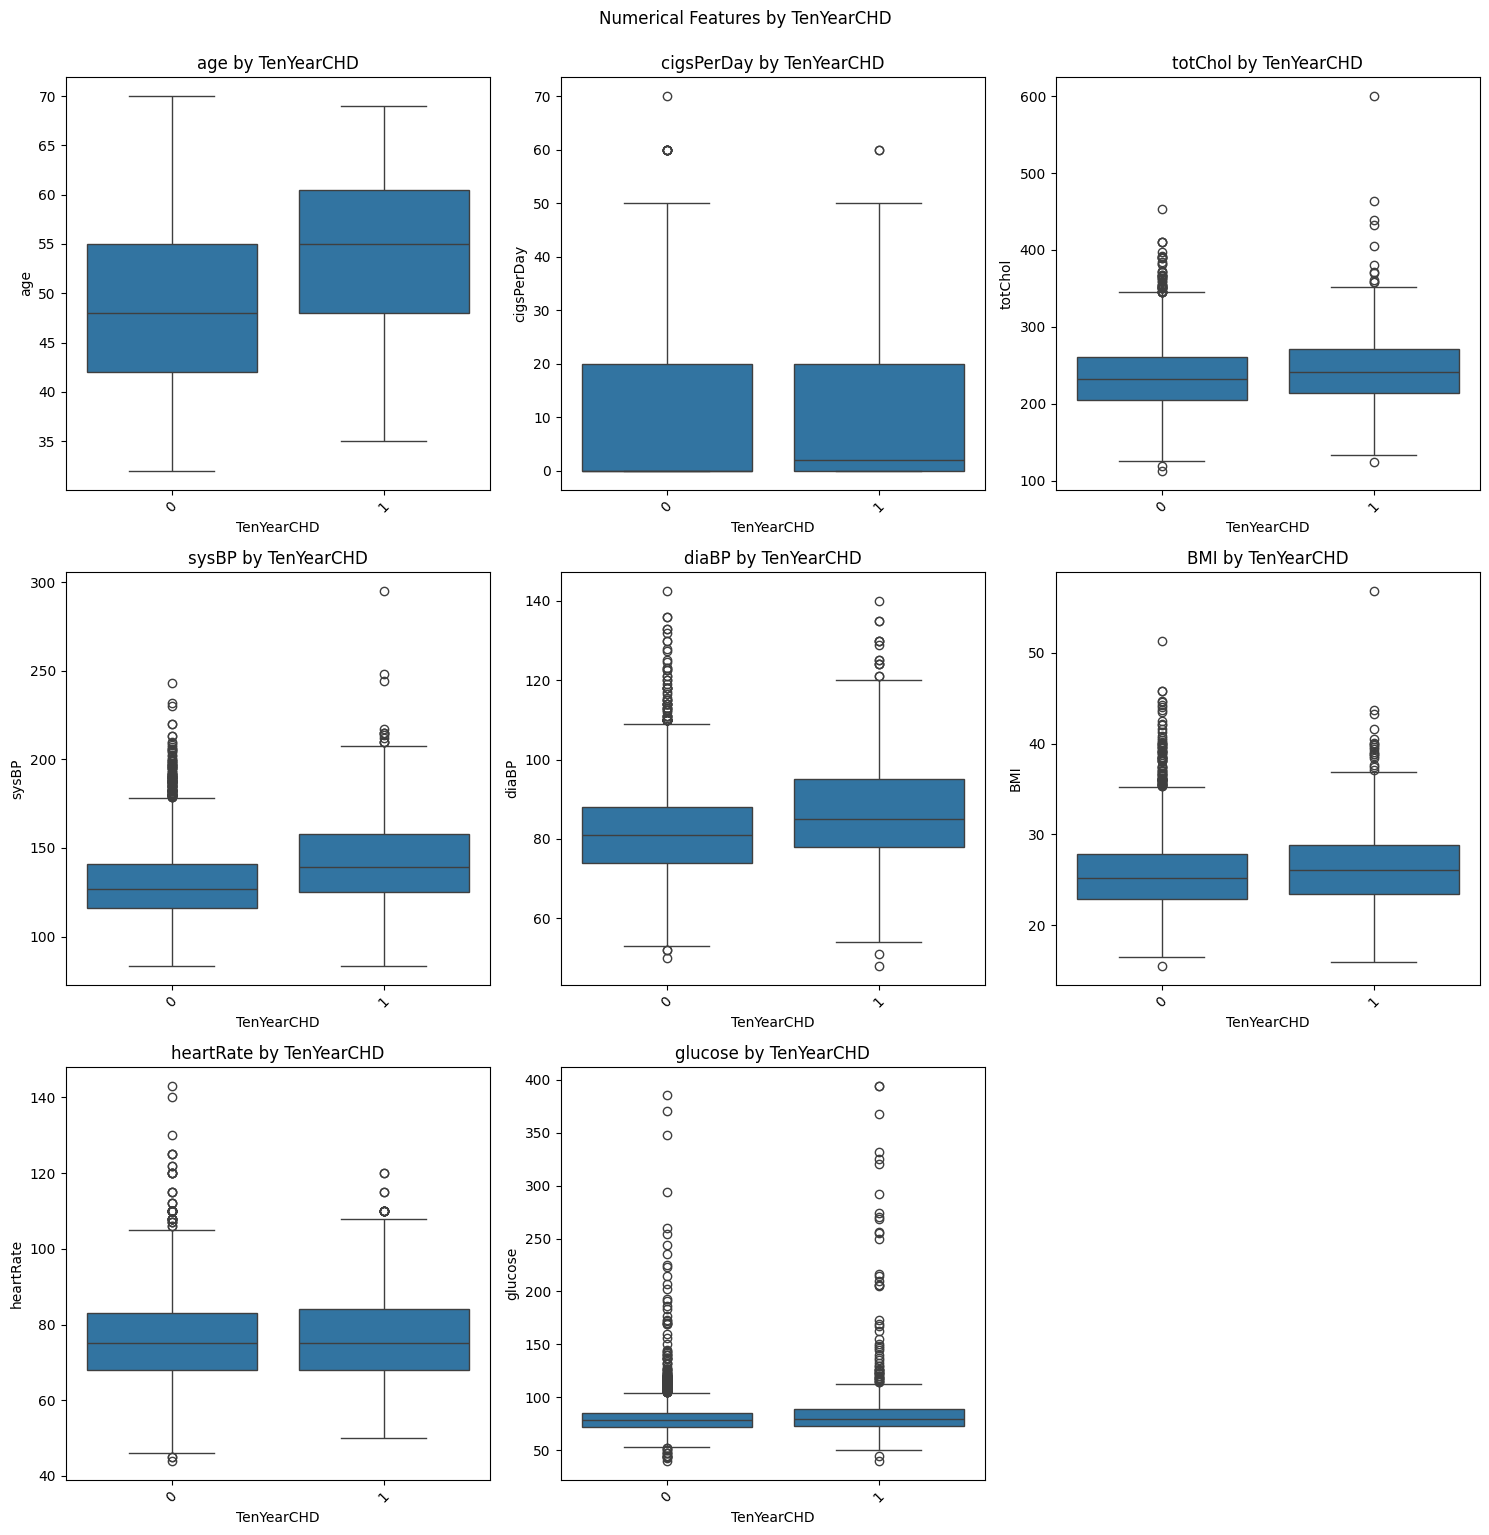

In [9]:
# Numerical - Categorical

import seaborn as sns
import matplotlib.pyplot as plt

# Select numerical and categorical features
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='category').columns

# Loop through each categorical feature
for cat_feature in categorical_features:
    # Set up the grid layout
    n_features = len(numerical_features)
    n_cols = 3  # Number of plots per row
    n_rows = (n_features // n_cols) + (n_features % n_cols > 0)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
    axes = axes.flatten()
    
    # Create boxplots for each numerical feature
    for idx, num_feature in enumerate(numerical_features):
        ax = axes[idx]
        sns.boxplot(data=df, x=cat_feature, y=num_feature, ax=ax)
        ax.set_title(f"{num_feature} by {cat_feature}")
        ax.set_xlabel(cat_feature)
        ax.set_ylabel(num_feature)
        ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for readability

    # Remove unused subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    plt.suptitle(f"Numerical Features by {cat_feature}", y=1.02)
    plt.show()



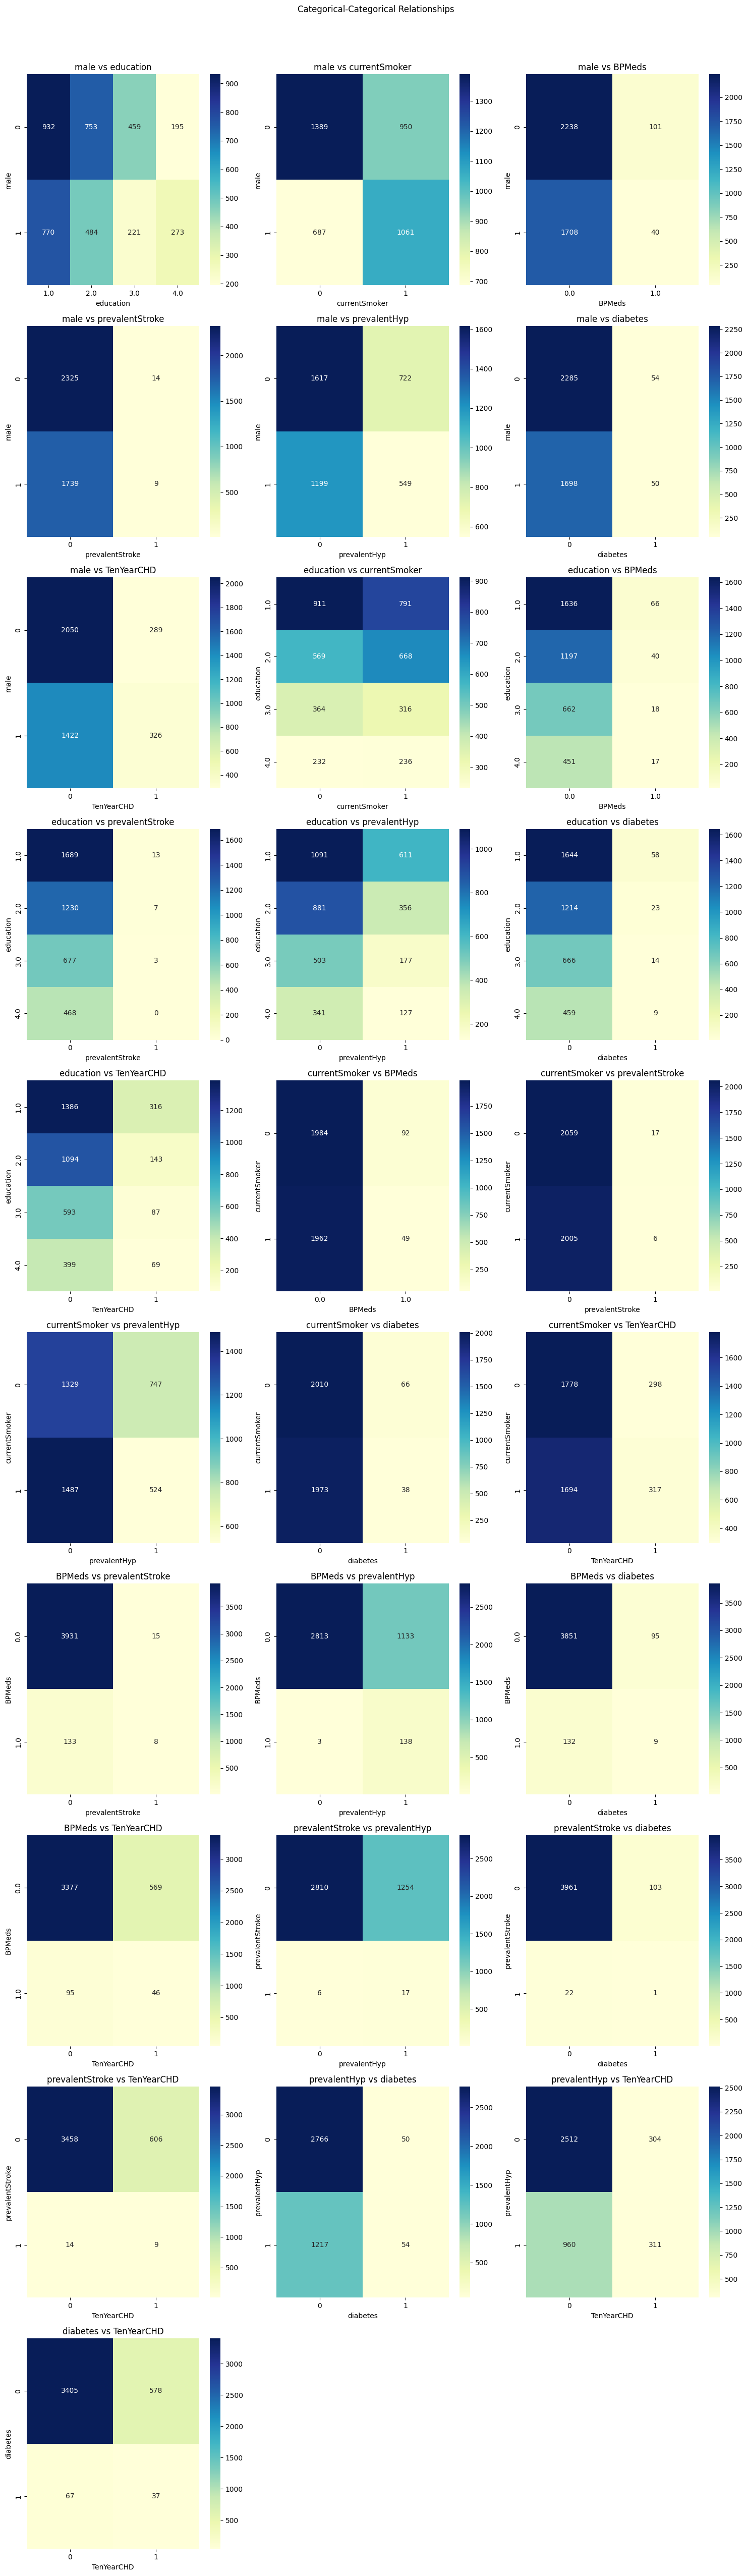

In [10]:
# Categorical - Categorical

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Select categorical features
categorical_features = df.select_dtypes(include='category').columns

# Create all unique combinations of categorical features
combinations = list(itertools.combinations(categorical_features, 2))

# Set up grid dimensions
n_plots = len(combinations)
n_cols = 3  # Number of plots per row
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each combination and create a heatmap
for idx, (cat_feature1, cat_feature2) in enumerate(combinations):
    ax = axes[idx]
    # Create a contingency table
    contingency_table = pd.crosstab(df[cat_feature1], df[cat_feature2])
    # Plot the heatmap
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_title(f"{cat_feature1} vs {cat_feature2}")
    ax.set_xlabel(cat_feature2)
    ax.set_ylabel(cat_feature1)

# Remove unused subplots
for i in range(len(combinations), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Categorical-Categorical Relationships", y=1.02)
plt.show()



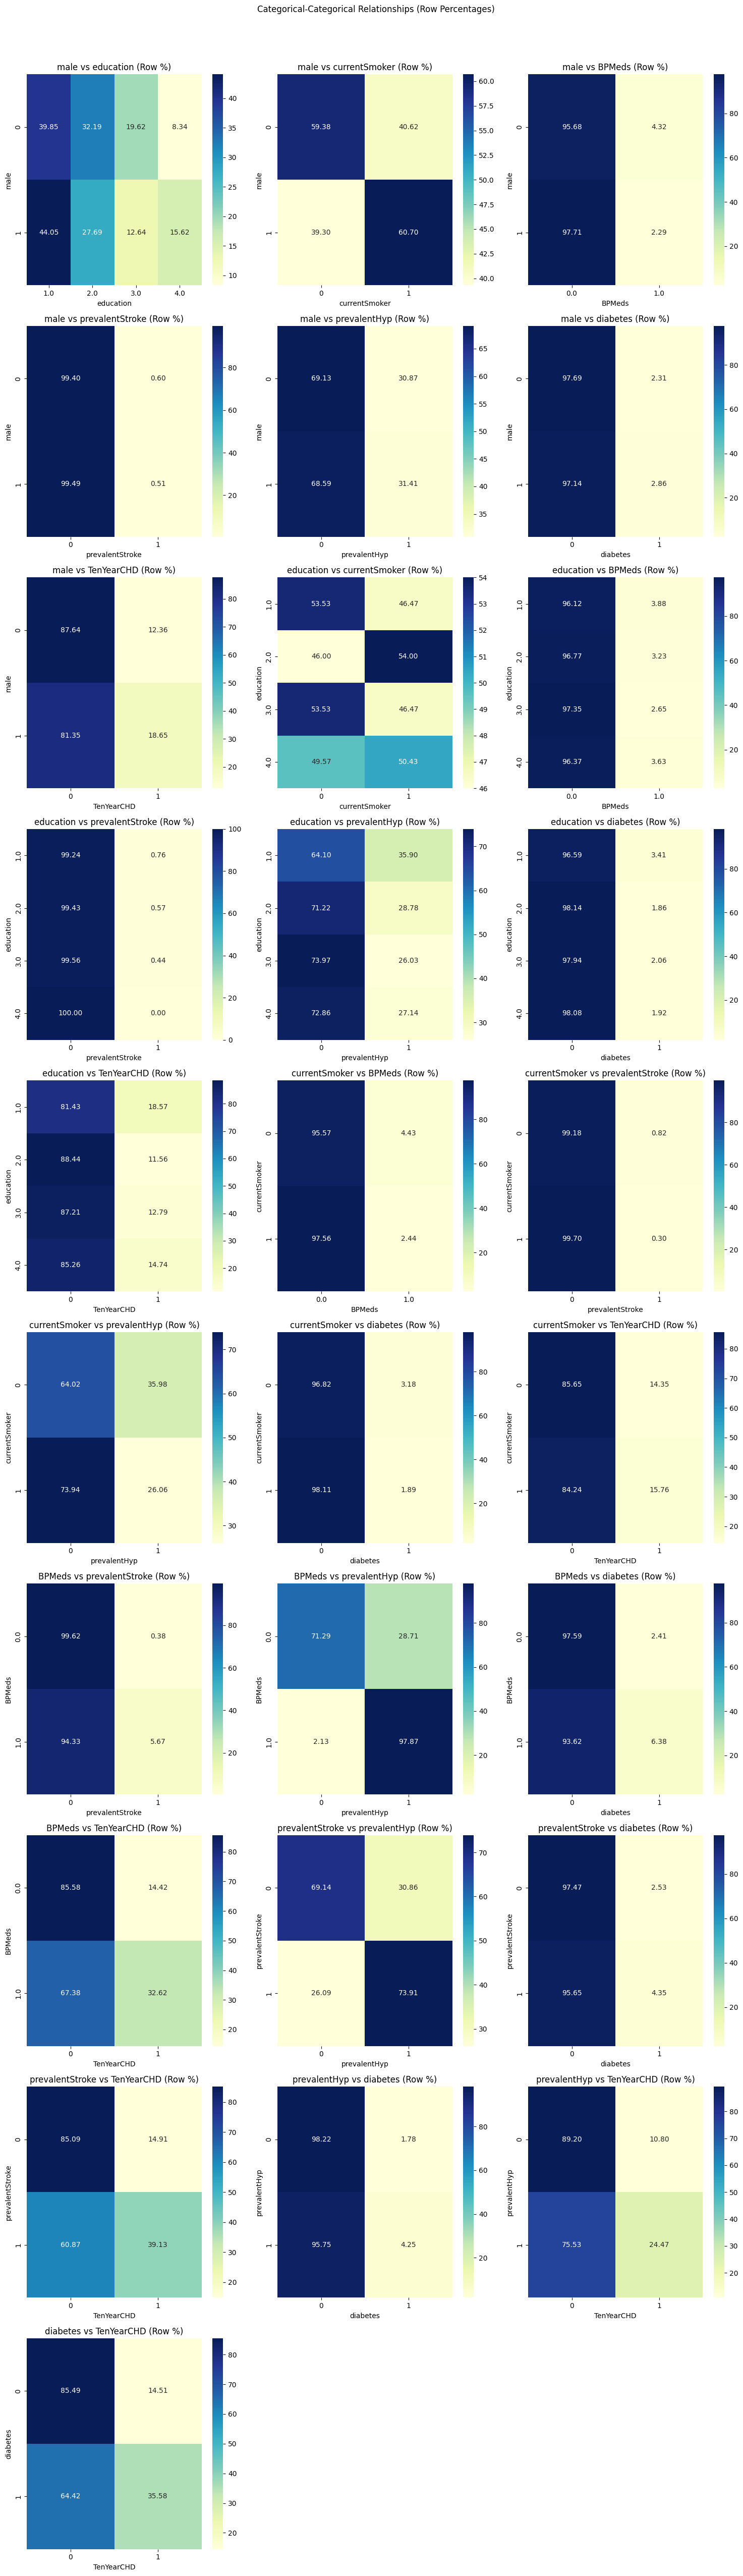

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Select categorical features
categorical_features = df.select_dtypes(include='category').columns

# Create all unique combinations of categorical features
combinations = list(itertools.combinations(categorical_features, 2))

# Set up grid dimensions
n_plots = len(combinations)
n_cols = 3  # Number of plots per row
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each combination and create a heatmap
for idx, (cat_feature1, cat_feature2) in enumerate(combinations):
    ax = axes[idx]
    # Create a normalized contingency table (percentages along rows)
    contingency_table = pd.crosstab(df[cat_feature1], df[cat_feature2], normalize='index') * 100
    # Plot the heatmap
    sns.heatmap(contingency_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
    ax.set_title(f"{cat_feature1} vs {cat_feature2} (Row %)")
    ax.set_xlabel(cat_feature2)
    ax.set_ylabel(cat_feature1)

# Remove unused subplots
for i in range(len(combinations), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Categorical-Categorical Relationships (Row Percentages)", y=1.02)
plt.show()


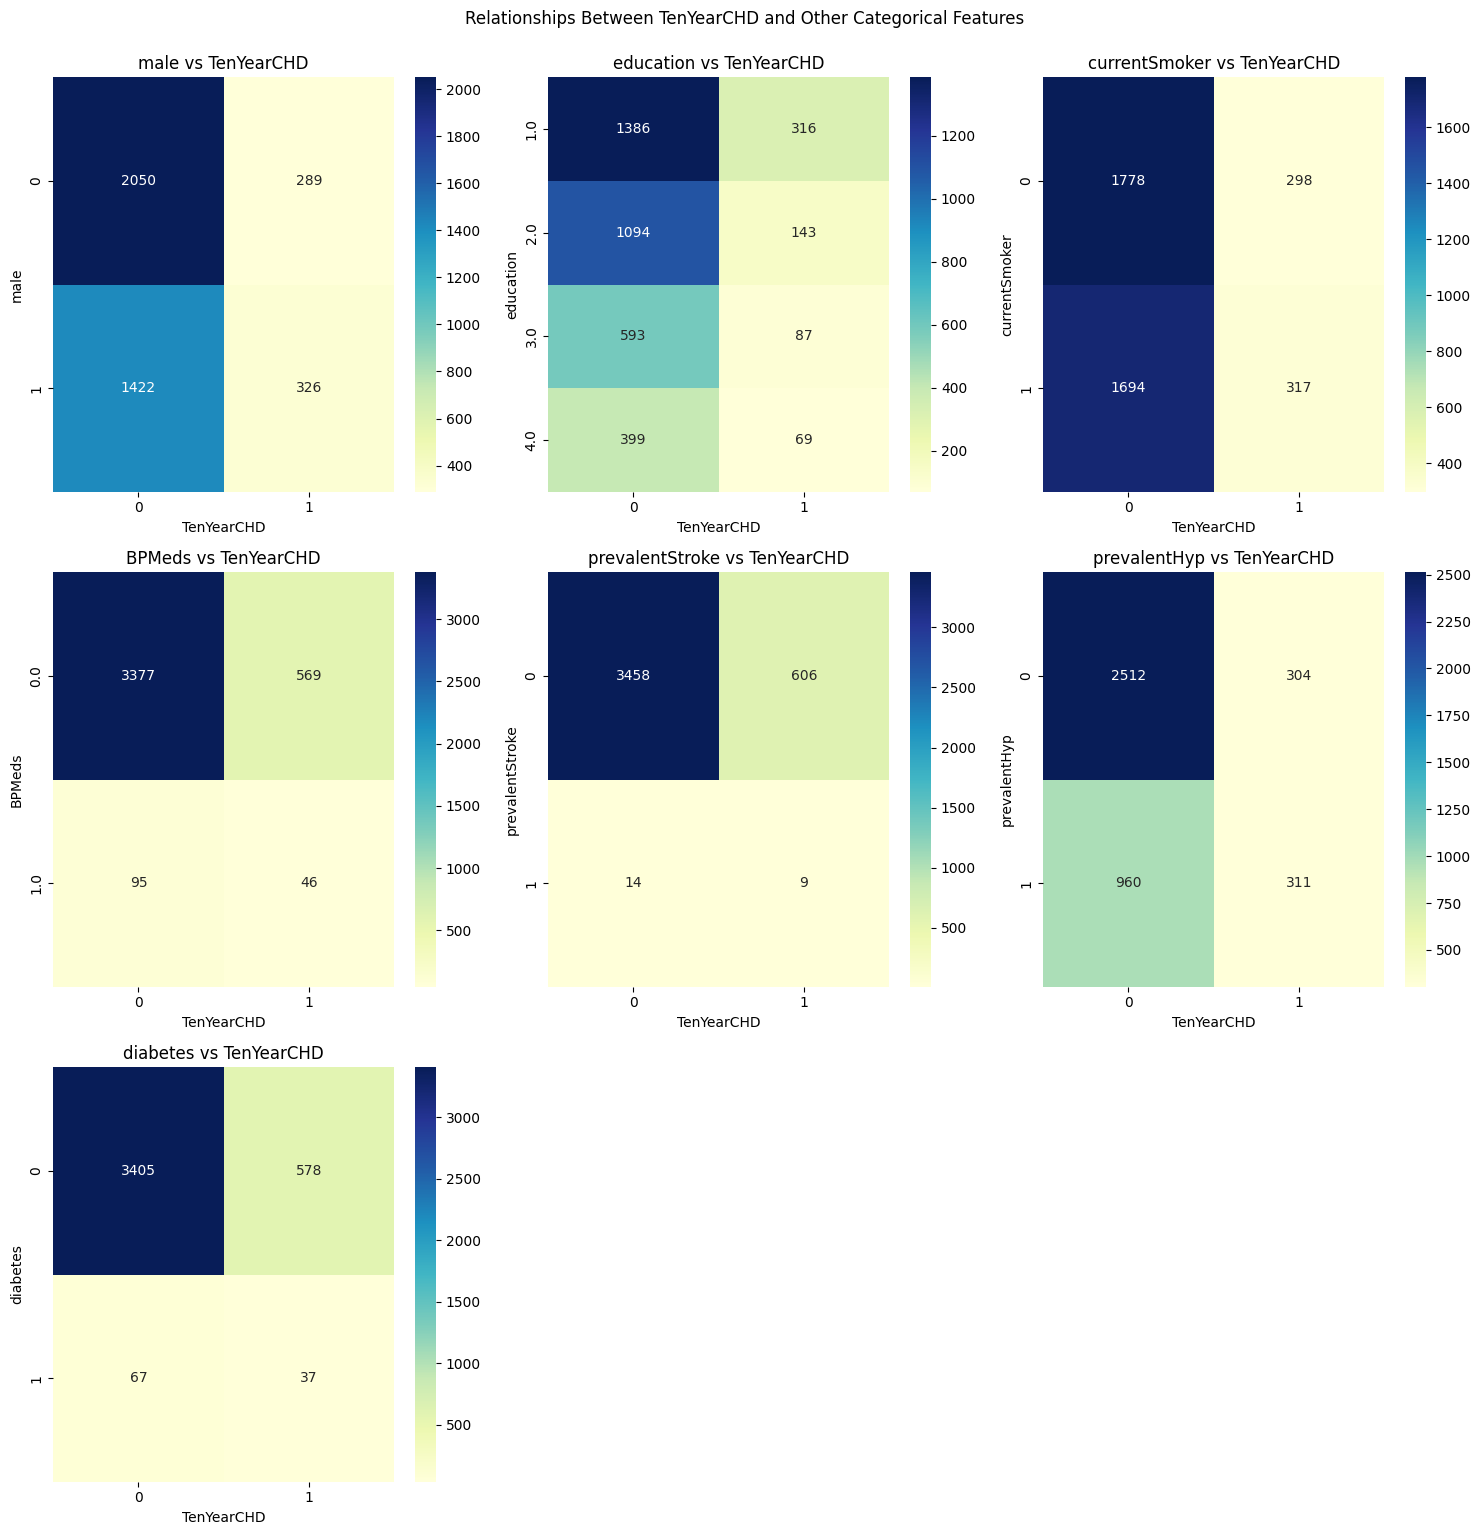

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical features
categorical_features = df.select_dtypes(include='category').columns

# Filter for combinations involving 'TenYearCHD'
target_feature = 'TenYearCHD'
combinations = [(feature, target_feature) for feature in categorical_features if feature != target_feature]

# Set up grid dimensions
n_plots = len(combinations)
n_cols = 3  # Number of plots per row
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each combination and create a heatmap
for idx, (cat_feature1, cat_feature2) in enumerate(combinations):
    ax = axes[idx]
    # Create a contingency table
    contingency_table = pd.crosstab(df[cat_feature1], df[cat_feature2])
    # Plot the heatmap
    sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_title(f"{cat_feature1} vs {cat_feature2}")
    ax.set_xlabel(cat_feature2)
    ax.set_ylabel(cat_feature1)

# Remove unused subplots
for i in range(len(combinations), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Relationships Between TenYearCHD and Other Categorical Features", y=1.02)
plt.show()


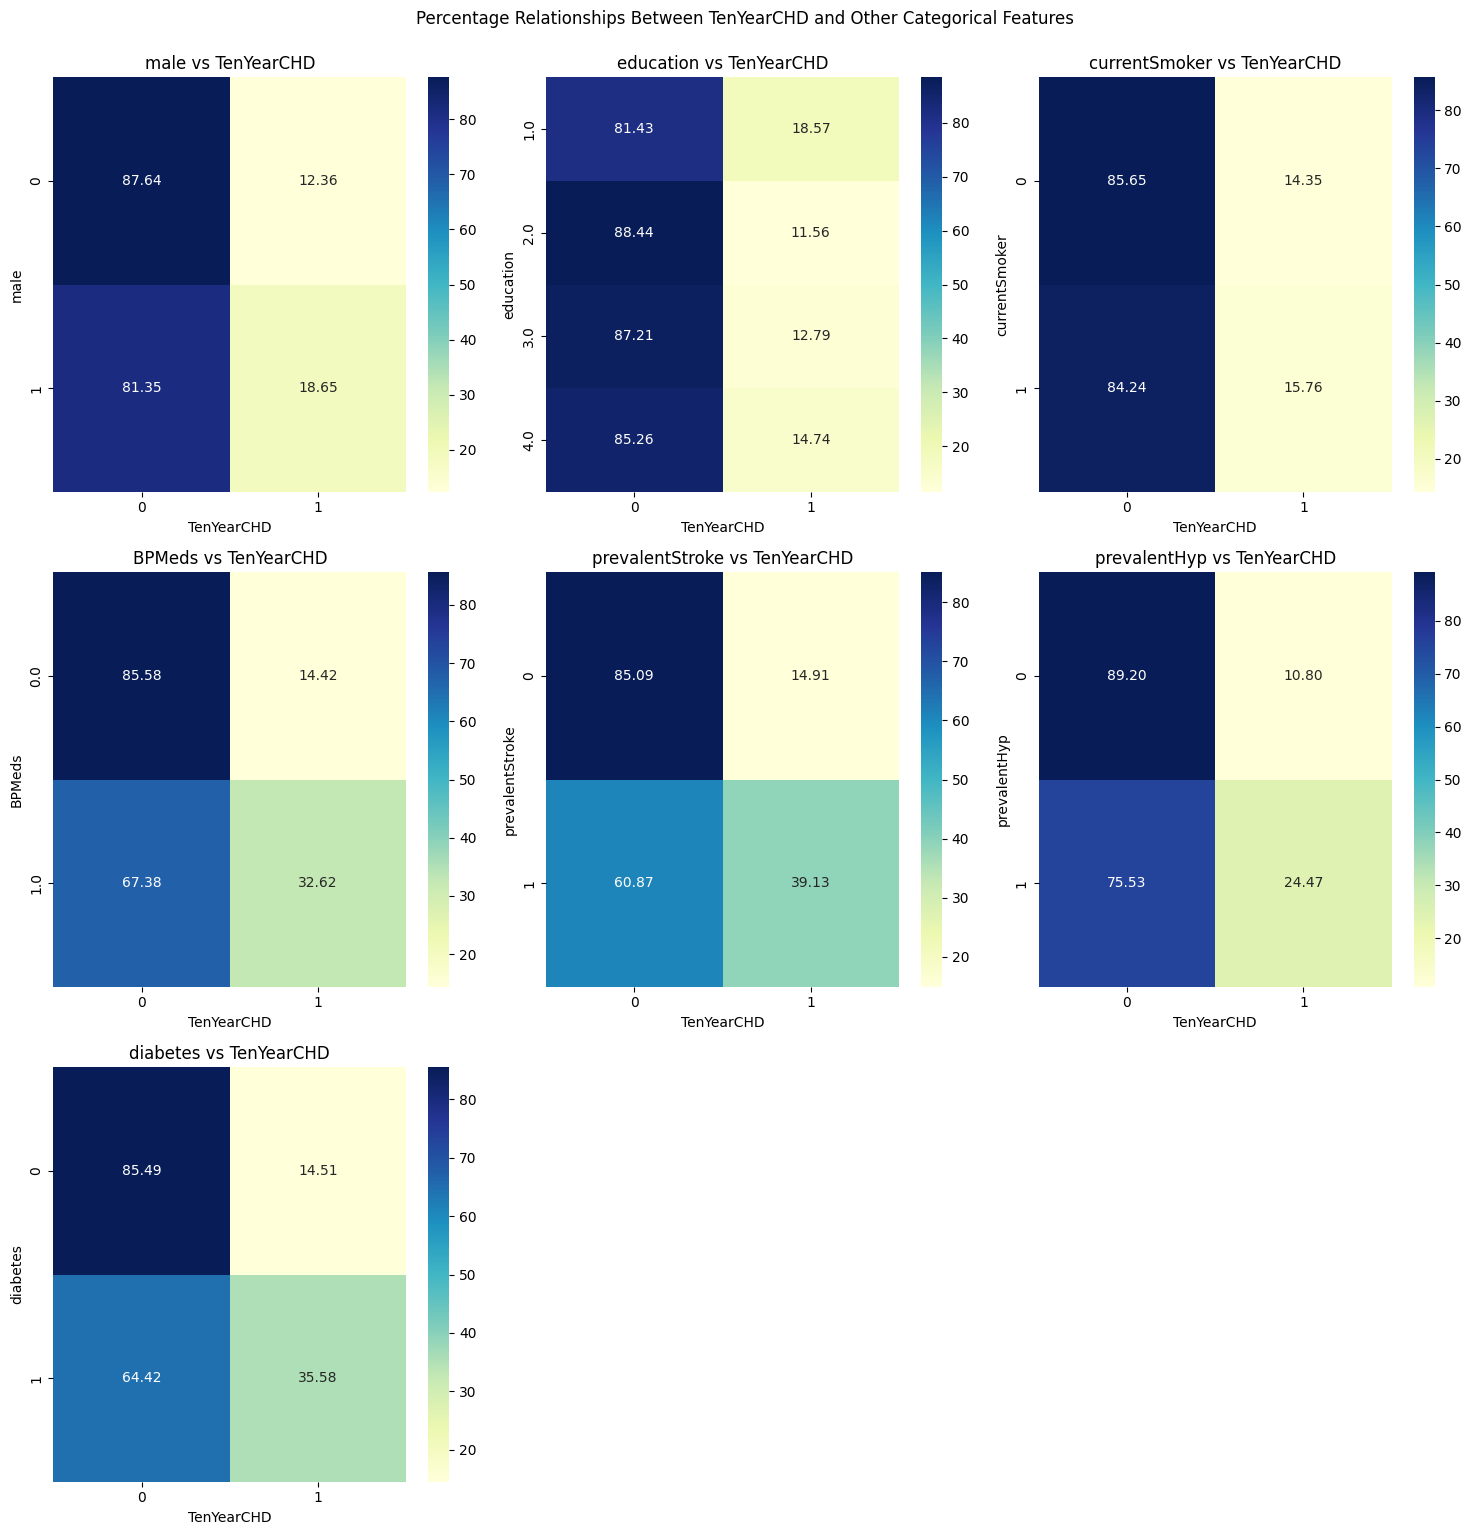

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical features
categorical_features = df.select_dtypes(include='category').columns

# Filter for combinations involving 'TenYearCHD'
target_feature = 'TenYearCHD'
combinations = [(feature, target_feature) for feature in categorical_features if feature != target_feature]

# Set up grid dimensions
n_plots = len(combinations)
n_cols = 3  # Number of plots per row
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each combination and create a heatmap
for idx, (cat_feature1, cat_feature2) in enumerate(combinations):
    ax = axes[idx]
    # Create a normalized contingency table
    contingency_table = pd.crosstab(df[cat_feature1], df[cat_feature2], normalize='index') * 100
    # Plot the heatmap
    sns.heatmap(contingency_table, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
    ax.set_title(f"{cat_feature1} vs {cat_feature2}")
    ax.set_xlabel(cat_feature2)
    ax.set_ylabel(cat_feature1)

# Remove unused subplots
for i in range(len(combinations), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle("Percentage Relationships Between TenYearCHD and Other Categorical Features", y=1.02)
plt.show()


In [27]:
from scipy.stats import pearsonr, spearmanr, f_oneway

from scipy.stats import pearsonr, spearmanr, f_oneway, chi2_contingency
import pandas as pd

# Define your relationships
relationships = [
    ("BMI", "sysBP", "numerical-numerical"),
    ("BMI", "diaBP", "numerical-numerical"),
    ("age", "sysBP", "numerical-numerical"),
    ("age", "diaBP", "numerical-numerical"),
    ("cigsPerDay", "male", "numerical-categorical"),
    ("sysBP", "education", "numerical-categorical"),
    ("diaBP", "education", "numerical-categorical"),
    ("age", "currentSmoker", "numerical-categorical"),
    ("age", "BPMeds", "numerical-categorical"),
    ("totChol", "BPMeds", "numerical-categorical"),
    ("sysBP", "BPMeds", "numerical-categorical"),
    ("diaBP", "BPMeds", "numerical-categorical"),
    ("age", "prevalentStroke", "numerical-categorical"),
    ("cigsPerDay", "prevalentStroke", "numerical-categorical"),
    ("sysBP", "prevalentStroke", "numerical-categorical"),
    ("diaBP", "prevalentStroke", "numerical-categorical"),
    ("BMI", "prevalentStroke", "numerical-categorical"),
    ("age", "prevalentHyp", "numerical-categorical"),
    ("totChol", "prevalentHyp", "numerical-categorical"),
    ("sysBP", "prevalentHyp", "numerical-categorical"),
    ("diaBP", "prevalentHyp", "numerical-categorical"),
    ("BMI", "prevalentHyp", "numerical-categorical"),
    ("age", "diabetes", "numerical-categorical"),
    ("sysBP", "diabetes", "numerical-categorical"),
    ("diaBP", "diabetes", "numerical-categorical"),
    ("BMI", "diabetes", "numerical-categorical"),
    ("heartRate", "diabetes", "numerical-categorical"),
    ("male", "BPMeds", "categorical-categorical"),
    ("currentSmoker", "BPMeds", "categorical-categorical"),
    ("currentSmoker", "prevalentHyp", "categorical-categorical"),
    ("currentSmoker", "diabetes", "categorical-categorical"),
    ("BPMeds", "prevalentHyp", "categorical-categorical"),
    ("prevalentStroke", "prevalentHyp", "categorical-categorical"),
]

# Store results
results = []

for feature1, feature2, rel_type in relationships:
    if rel_type == "numerical-numerical":
        # Pearson correlation
        r, p_value = pearsonr(df[feature1], df[feature2])
        results.append((feature1, feature2, "Pearson Correlation", r, p_value))
    elif rel_type == "numerical-categorical":
        # ANOVA test
        groups = [df[df[feature2] == category][feature1] for category in df[feature2].unique()]
        f_stat, p_value = f_oneway(*groups)
        results.append((feature1, feature2, "ANOVA", f_stat, p_value))
    elif rel_type == "categorical-categorical":
        # Chi-Square test
        contingency_table = pd.crosstab(df[feature1], df[feature2])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        results.append((feature1, feature2, "Chi-Square", chi2, p_value))

# Convert results to a DataFrame for easy filtering
results_df = pd.DataFrame(results, columns=["Feature1", "Feature2", "Test", "Statistic", "P-Value"])

# Filter significant results
significant_results = results_df[results_df["P-Value"] < 0.05]
print("Significant Relationships:\n", significant_results)
results_df.to_excel('stat_test_dep.xlsx')


Significant Relationships:
            Feature1         Feature2                 Test    Statistic  \
0               BMI            sysBP  Pearson Correlation     0.326084   
1               BMI            diaBP  Pearson Correlation     0.378098   
2               age            sysBP  Pearson Correlation     0.393221   
3               age            diaBP  Pearson Correlation     0.206120   
4        cigsPerDay             male                ANOVA   468.452745   
5             sysBP        education                ANOVA    25.212668   
6             diaBP        education                ANOVA     7.118225   
7               age    currentSmoker                ANOVA   198.912189   
8               age           BPMeds                ANOVA    84.961628   
9           totChol           BPMeds                ANOVA    29.497577   
10            sysBP           BPMeds                ANOVA   335.822080   
11            diaBP           BPMeds                ANOVA   181.311710   
12        

In [14]:
from scipy.stats import pearsonr, spearmanr, f_oneway

from scipy.stats import pearsonr, spearmanr, f_oneway, chi2_contingency
import pandas as pd
import openpyxl

# Define your relationships
relationships = [
    ("age", "TenYearCHD", "numerical-categorical"),
    ("cigsPerDay", "TenYearCHD", "numerical-categorical"),
    ("totChol", "TenYearCHD", "numerical-categorical"),
    ("sysBP", "TenYearCHD", "numerical-categorical"),
    ("diaBP", "TenYearCHD", "numerical-categorical"),
    ("BMI", "TenYearCHD", "numerical-categorical"),
    ("heartRate", "TenYearCHD", "numerical-categorical"),
    ("glucose", "TenYearCHD", "numerical-categorical"),
    ("male", "TenYearCHD", "categorical-categorical"),
    ("education", "TenYearCHD", "categorical-categorical"),
    ("prevalentStroke", "TenYearCHD", "categorical-categorical"),
    ("prevalentHyp", "TenYearCHD", "categorical-categorical"),
    ("BPMeds", "TenYearCHD", "categorical-categorical"),
    ("currentSmoker", "TenYearCHD", "categorical-categorical"),
    ("diabetes", "TenYearCHD", "categorical-categorical"),
]

# Store results
results = []

for feature1, feature2, rel_type in relationships:
    if rel_type == "numerical-numerical":
        # Pearson correlation
        r, p_value = pearsonr(df[feature1], df[feature2])
        results.append((feature1, feature2, "Pearson Correlation", r, p_value))
    elif rel_type == "numerical-categorical":
        # ANOVA test
        groups = [df[df[feature2] == category][feature1] for category in df[feature2].unique()]
        f_stat, p_value = f_oneway(*groups)
        results.append((feature1, feature2, "ANOVA", f_stat, p_value))
    elif rel_type == "categorical-categorical":
        # Chi-Square test
        contingency_table = pd.crosstab(df[feature1], df[feature2])
        chi2, p_value, _, _ = chi2_contingency(contingency_table)
        results.append((feature1, feature2, "Chi-Square", chi2, p_value))

# Convert results to a DataFrame for easy filtering
results_df = pd.DataFrame(results, columns=["Feature1", "Feature2", "Test", "Statistic", "P-Value"])

# Filter significant results
significant_results = results_df[results_df["P-Value"] < 0.05]
print("Significant Relationships:\n", significant_results)

print(results_df)
results_df.to_excel('stat_test_TYCHD.xlsx')


Significant Relationships:
            Feature1    Feature2        Test   Statistic       P-Value
0               age  TenYearCHD       ANOVA  218.459509  3.378043e-48
1        cigsPerDay  TenYearCHD       ANOVA   12.835121  3.441398e-04
2           totChol  TenYearCHD       ANOVA   31.580487  2.040961e-08
3             sysBP  TenYearCHD       ANOVA  199.405486  3.044709e-44
4             diaBP  TenYearCHD       ANOVA   88.698531  7.470370e-21
5               BMI  TenYearCHD       ANOVA   19.989357  7.998740e-06
7           glucose  TenYearCHD       ANOVA   58.493722  2.527249e-14
8              male  TenYearCHD  Chi-Square   30.512281  3.317596e-08
9         education  TenYearCHD  Chi-Square   30.989098  8.545531e-07
10  prevalentStroke  TenYearCHD  Chi-Square    8.685019  3.208362e-03
11     prevalentHyp  TenYearCHD  Chi-Square  127.013789  1.844872e-29
12           BPMeds  TenYearCHD  Chi-Square   33.882680  5.853750e-09
14         diabetes  TenYearCHD  Chi-Square   33.553927  6.931

### For above, all features within the data set share a statistically significant relationship with TenYearCHD besides currentSmoker


# Clustering

In [15]:
pca = PCA()
X_pca = pca.fit_transform(preprocessed_df)

loadings = pd.DataFrame(pca.components_.T, 
                        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
                        index=preprocessed_df.columns)

print("PCA Loadings:")
print(loadings)

PCA Loadings:
                        PC1       PC2       PC3       PC4       PC5       PC6  \
age                0.336091 -0.232058  0.294241 -0.412843 -0.108353 -0.293760   
cigsPerDay        -0.162503  0.731100  0.116914 -0.223933 -0.169377 -0.019738   
totChol            0.236058 -0.007394  0.485414 -0.501984  0.299198  0.441337   
sysBP              0.539698  0.144308 -0.109975 -0.002590 -0.012481 -0.296607   
diaBP              0.501584  0.217421 -0.270023  0.064568  0.001710 -0.153516   
BMI                0.332306  0.048859 -0.285709  0.102197 -0.251223  0.761769   
heartRate          0.155082  0.290593  0.290171  0.506137  0.619594  0.049376   
glucose            0.132679 -0.044267  0.619511  0.465756 -0.569065  0.001361   
male_0             0.017432 -0.145706  0.053639  0.084698  0.196967 -0.033252   
male_1            -0.017432  0.145706 -0.053639 -0.084698 -0.196967  0.033252   
education_1.0      0.058363 -0.016101  0.011192 -0.047764 -0.063250  0.015689   
education_2.0 

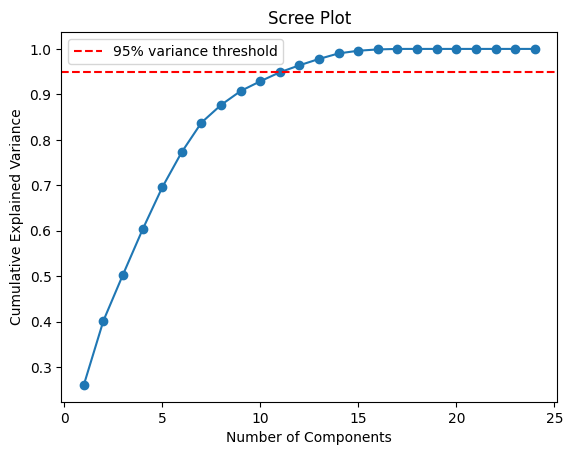

In [16]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance threshold')
plt.legend()
plt.show()

Number of components explaining 95% variance: 12


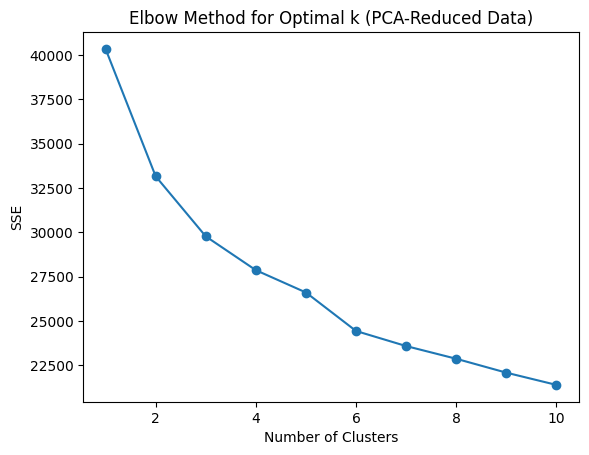

Silhouette Score with PCA-Reduced Data: 0.11791122467315181


In [64]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Step 1: Fit PCA and determine the number of components explaining 95% variance
pca = PCA()
pca_data = pca.fit_transform(preprocessed_df)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Determine the number of components for 95% variance
num_components = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% variance: {num_components}")

# Transform data using the selected components
pca = PCA(n_components=num_components)
reduced_data = pca.fit_transform(preprocessed_df)

# Step 2: Perform K-Means Clustering on Reduced Data
# Determine the optimal number of clusters using the elbow method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), sse, marker='o')
plt.title("Elbow Method for Optimal k (PCA-Reduced Data)")
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

# Fit K-Means with the chosen number of clusters
kmeans = KMeans(n_clusters=6, random_state=42)  # Adjust n_clusters based on the elbow plot
clusters = kmeans.fit_predict(reduced_data)
df['Cluster'] = clusters  # Add cluster labels to the dataset

# Step 3: Calculate Silhouette Score
sil_score = silhouette_score(reduced_data, clusters)
print(f"Silhouette Score with PCA-Reduced Data: {sil_score}")




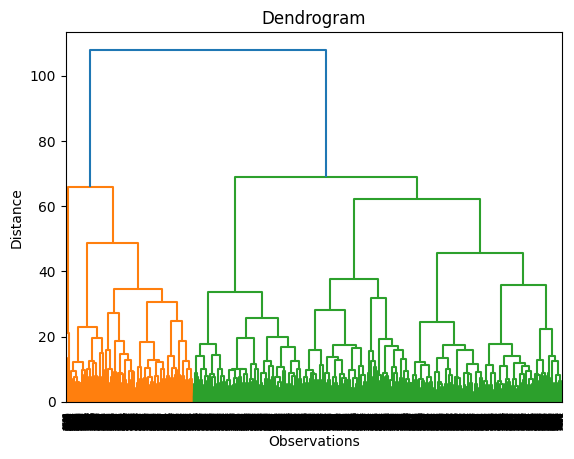

In [18]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering
linkage_matrix = linkage(preprocessed_df, method='ward')
dendrogram(linkage_matrix)
plt.title("Dendrogram")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()

# Fit Agglomerative Clustering with a chosen number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=3)
df['Cluster_Hierarchical'] = agg_clustering.fit_predict(preprocessed_df)


In [19]:
preprocessed_df.columns

Index(['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate',
       'glucose', 'male_0', 'male_1', 'education_1.0', 'education_2.0',
       'education_3.0', 'education_4.0', 'currentSmoker_0', 'currentSmoker_1',
       'BPMeds_0.0', 'BPMeds_1.0', 'prevalentStroke_0', 'prevalentStroke_1',
       'prevalentHyp_0', 'prevalentHyp_1', 'diabetes_0', 'diabetes_1'],
      dtype='object')

In [20]:
# Numeric summaries (mean)
numeric_summary = df.select_dtypes(include='number').groupby(df['Cluster']).mean()

# Categorical summaries (mode)
categorical_summary = df.select_dtypes(include='category').groupby(df['Cluster']).agg(lambda x: x.mode().iloc[0])

# Combine the results
cluster_profiles = pd.concat([numeric_summary, categorical_summary], axis=1)

# Display the cluster profiles
cluster_profiles


age  cigsPerDay     totChol       sysBP      diaBP        BMI  \
Cluster                                                                        
0        45.724746   20.807458  229.501698  122.296949  78.093220  24.473729   
1        55.278517    5.343156  253.951368  159.991920  96.113593  28.178080   
2        49.295513    0.421795  231.809179  123.135577  78.455128  25.389103   

         heartRate    glucose  Cluster  Cluster_Hierarchical male education  \
Cluster                                                                       
0        76.216949  79.501804      0.0              1.444746    1       1.0   
1        79.811787  86.429594      1.0              0.203422    0       1.0   
2        72.974359  80.670674      2.0              1.013462    0       1.0   

        currentSmoker BPMeds prevalentStroke prevalentHyp diabetes TenYearCHD  
Cluster                                                                        
0                   1    0.0               0            0        0          0  
1                   0    0.0               0            1        0          0  
2                   0    0.0               0            0        0          0

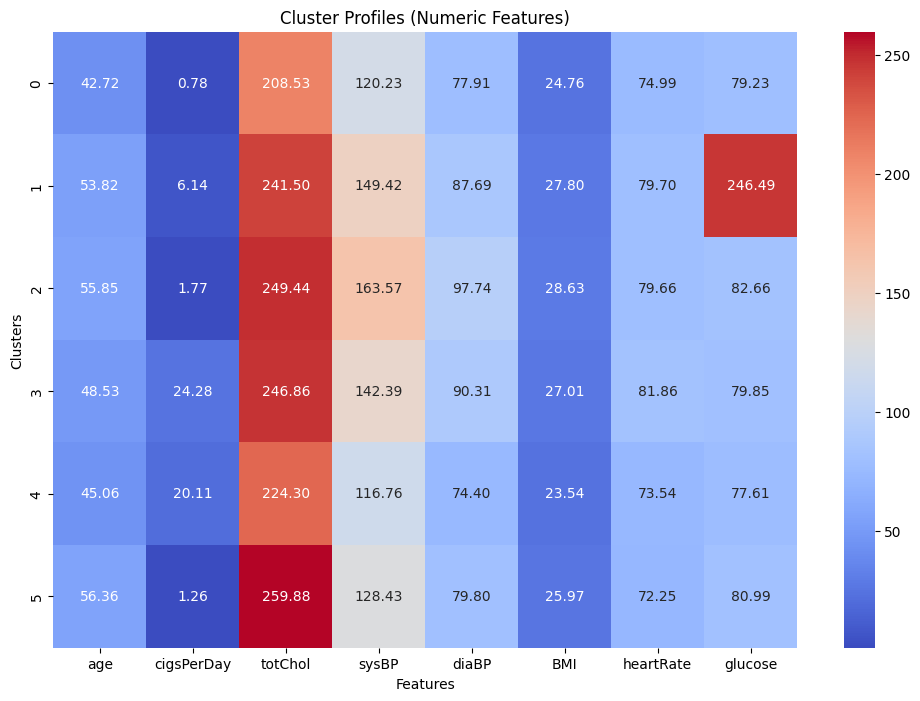

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

# Numeric cluster profiles
numeric_summary = df.select_dtypes(include='number').groupby(df['Cluster']).mean()
numeric_summary.drop(columns=['Cluster', 'Cluster_Hierarchical', 'TenYearCHD'], inplace=True)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_summary, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Cluster Profiles (Numeric Features)")
plt.xlabel("Features")
plt.ylabel("Clusters")
plt.show()


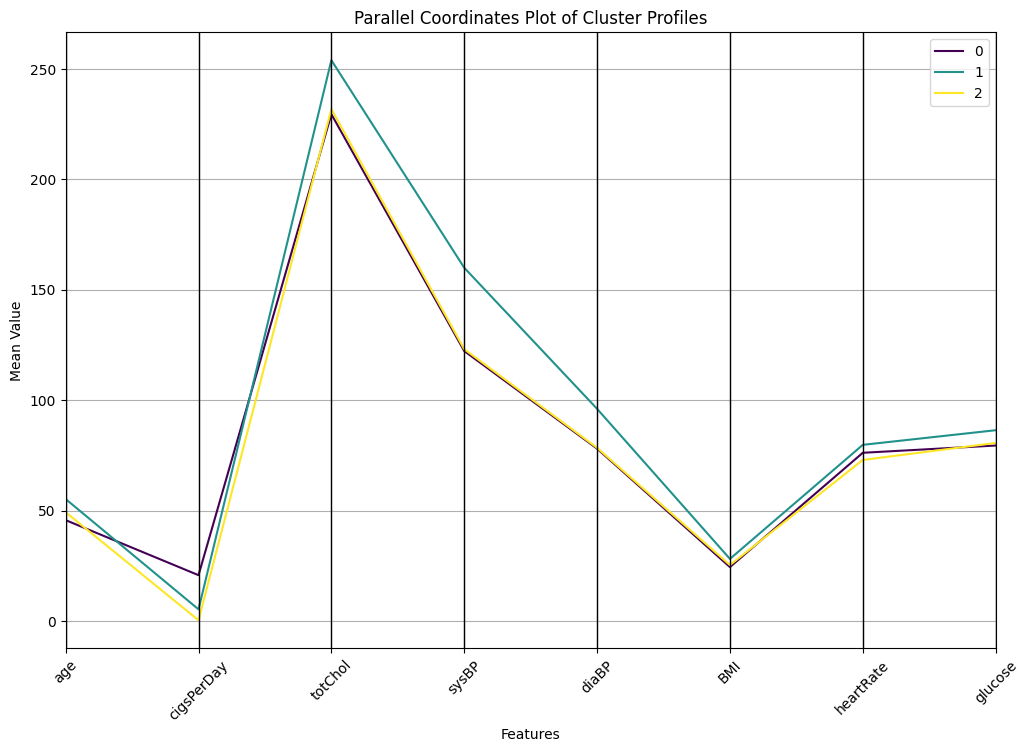

In [22]:
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates plot
cluster_profiles = numeric_summary.reset_index()
cluster_profiles['Cluster'] = cluster_profiles['Cluster'].astype(str)  # Convert cluster to string for coloring

# Plot parallel coordinates
plt.figure(figsize=(12, 8))
parallel_coordinates(cluster_profiles, class_column='Cluster', colormap='viridis')
plt.title("Parallel Coordinates Plot of Cluster Profiles")
plt.xlabel("Features")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.show()


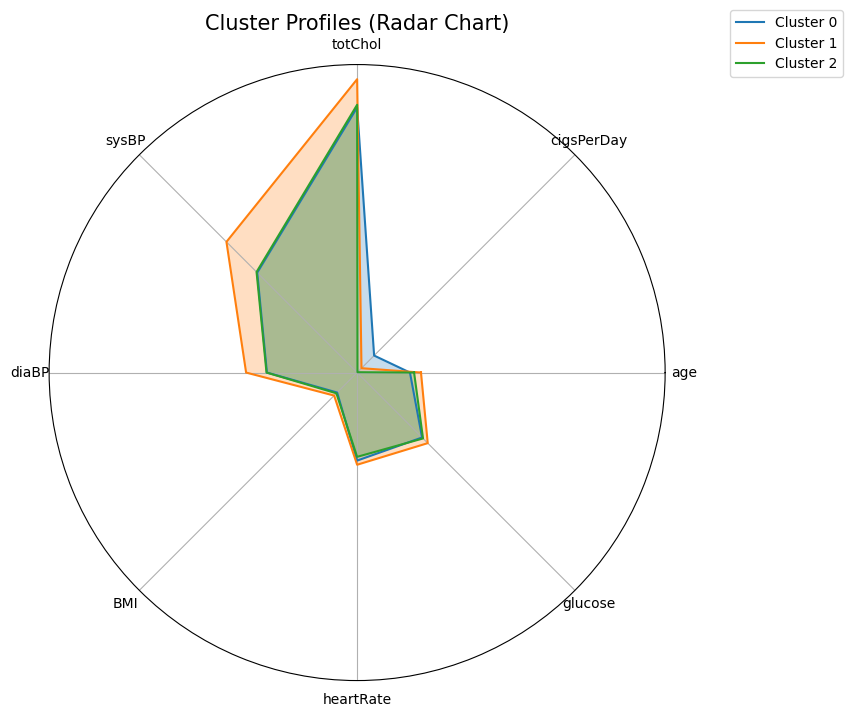

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
categories = list(numeric_summary.columns)
num_clusters = len(numeric_summary)
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Add the first angle to close the plot
angles += angles[:1]

# Plot for each cluster
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
for cluster_idx in range(num_clusters):
    values = numeric_summary.iloc[cluster_idx].tolist()
    values += values[:1]  # Repeat the first value to close the circle
    ax.plot(angles, values, label=f"Cluster {cluster_idx}")
    ax.fill(angles, values, alpha=0.25)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
plt.title("Cluster Profiles (Radar Chart)", size=15)
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()


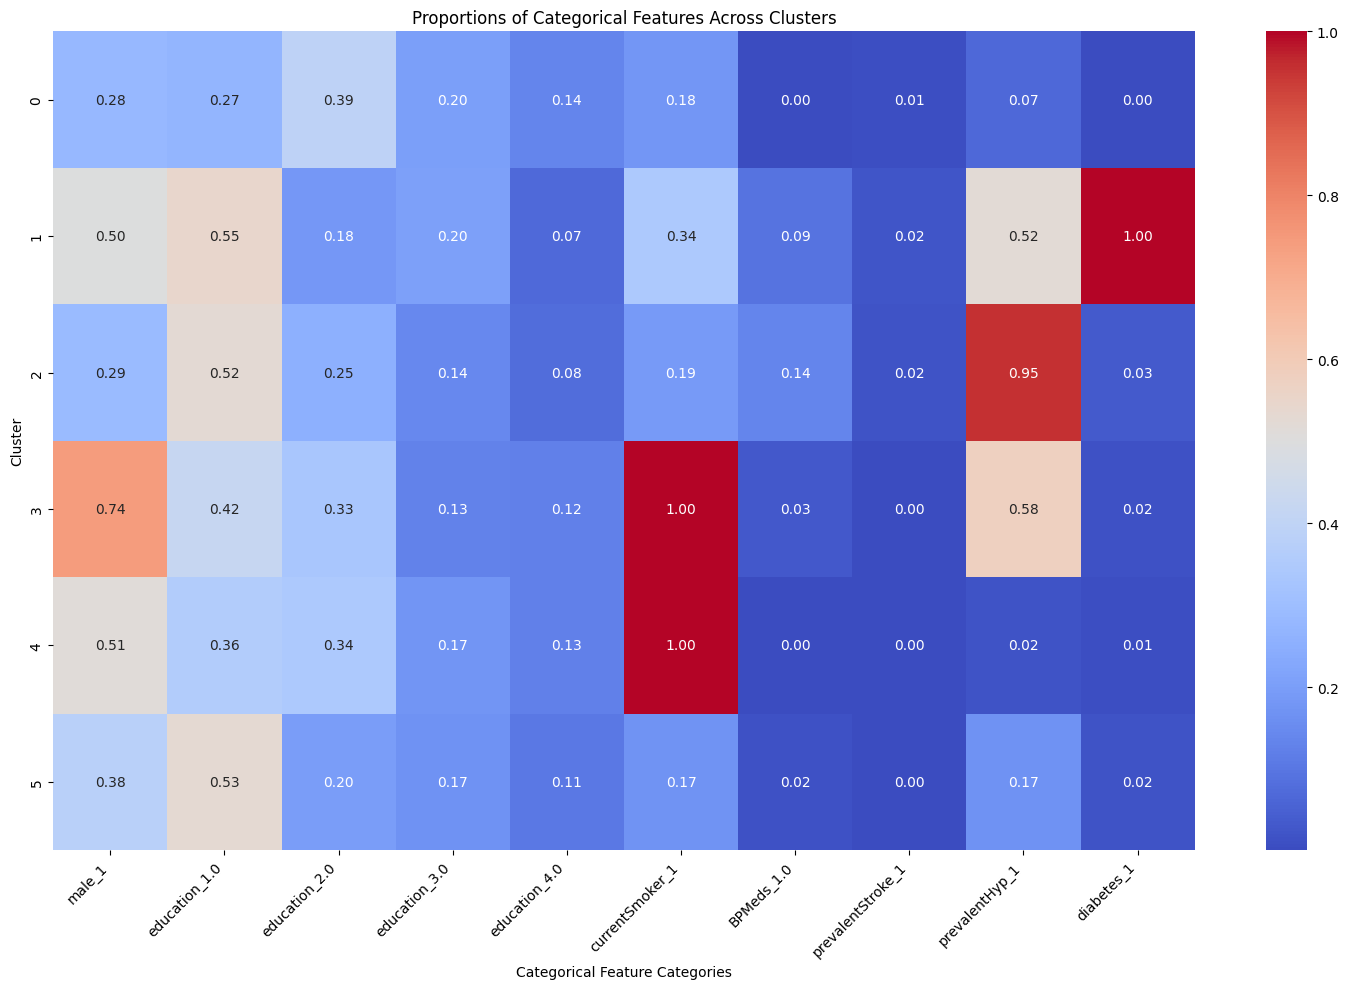

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select categorical features
categorical_features = df.select_dtypes(include='category').columns

# Compute proportions for all categorical features by cluster
all_proportions = []
for feature in categorical_features:
    # Calculate proportions
    cat_summary = df.groupby('Cluster')[feature].value_counts(normalize=True).unstack()
    # Add feature name as a prefix to categories for clarity
    cat_summary.columns = [f"{feature}_{category}" for category in cat_summary.columns]
    all_proportions.append(cat_summary)

# Combine all proportions into a single DataFrame
combined_proportions = pd.concat(all_proportions, axis=1)
#combined_proportions.drop(columns=['male_0', 'currentSmoker_0', 'BPMeds_0.0', 'prevalentStroke_0', 'prevalentHyp_0', 'diabetes_0', 'TenYearCHD_0', 'TenYearCHD_1'], inplace=True)
combined_proportions.drop(columns=['male_0', 'currentSmoker_0', 'BPMeds_0.0', 'prevalentStroke_0', 'prevalentHyp_0', 'diabetes_0'], inplace=True)

# Plot the heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(combined_proportions, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Proportions of Categorical Features Across Clusters")
plt.xlabel("Categorical Feature Categories")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [76]:
# Convert 'TenYearCHD' to numeric if necessary
df['TenYearCHD'] = df['TenYearCHD'].astype(int)

# Calculate the proportion of positives for each cluster
chd_proportions = df[['Cluster', 'TenYearCHD']].groupby('Cluster').mean()

cluster_count = df.groupby('Cluster').count()
cluster_count['Count'] = cluster_count['male']

#cluster_count = df[['Cluster']].groupby('Cluster').count()

print(chd_proportions)

chd_proportions.to_excel('CHD_Prop.xlsx')


         TenYearCHD
Cluster            
0          0.042286
1          0.454545
2          0.251758
3          0.213805
4          0.121593
5          0.149615


In [77]:
cluster_count['Count'].to_excel('Cluster_counts.xlsx')